In [1]:
%load_ext autoreload
%load_ext notexbook
%autoreload 2
%load_ext autotime

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx

plt.style.use("../config/custom_plt.mplstyle")

colors = [
    "#7494d3",
    "#5cb545",
    "#9956c6",
    "#a7b338",
    "#6a6bc6",
    "#d09e40",
    "#ce62bb",
    "#56be85",
    "#d1477d",
    "#397f4d",
    "#cf4b4a",
    "#40bbc1",
    "#d8662c",
    "#99af66",
    "#b76989",
    "#6d7127",
    "#b6744a"
]

time: 1.37 s (started: 2024-01-10 12:25:48 +01:00)


In [2]:
# %texify --code-font-family Monaco --linespread 1.2 --code-font-size 13

time: 1.16 ms (started: 2024-01-10 12:25:49 +01:00)


In [3]:
%load_ext Cython

time: 371 ms (started: 2024-01-10 12:25:49 +01:00)


In [4]:
%%cython --compile-args=-ffast-math --compile-args=-funroll-loops --compile-args=-ftree-loop-distribution --compile-args=-mtune=native
# distutils: language = c++

cimport cython
cimport numpy as np
import numpy as np
from libcpp.vector cimport vector
from libcpp cimport bool

from libc.math cimport exp, pi, cos, sin, sqrt, pow, acos
    
cdef class FractionNodesVsNeighbours:
    
    cdef int dim, n_labels
    cdef list labels, nodes
    cdef public np.float64_t[:, :] distance_matrix
    cdef public np.float64_t[:] cluster_probabilities
    
    
    def __init__(self, int dim, np.float64_t[:, :] positions, np.float64_t[:] thetas, list labels):
        # NOTE: list of labels should start with 0 and go to (n_labels - 1)
        self.dim = dim
        self.distance_matrix = self.get_distance_matrix(dim, positions, thetas)
        self.labels = labels
        self.nodes = list(np.arange(len(labels)))
        self.n_labels = len(set(self.labels))
        self.compute_probability_per_label()
        
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision      
    cdef compute_probability_per_label(self):
        cdef dict n_nodes_per_group = {}
        for i, l in enumerate(self.labels):
            if l not in n_nodes_per_group:
                n_nodes_per_group[l] = 0
            n_nodes_per_group[l] += 1
            
        self.cluster_probabilities = np.zeros(self.n_labels)    
        for l, v in n_nodes_per_group.items():
            self.cluster_probabilities[l] = v / len(self.labels)
    
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def compute_fraction_nodes_vs_neighbours_all_classes(self, int num_n_neighbours=30):
        """
        Format of the output
        
        [{n_neighbours_1: [results for the n_neigbours, ..]}, {}, ...]
        """
        cdef dict results = {}
        all_n_neighbours = np.linspace(2, len(self.nodes), num=num_n_neighbours).astype(int)        
        for n_neighbours in all_n_neighbours:
            results[n_neighbours] = self.iterate_over_nodes(self.nodes, n_neighbours)
        return results
    
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    def compute_fraction_nodes_vs_neighbours_per_class(self, int num_n_neighbours=30):
        """
        Format of the output
        
        {label_1: [{n_neighbours_1: [results for the n_neigbours, ..]}, {}, ...],
         label_2: ...}
        """
        cdef dict nodes_per_group = {}    
        for i, l in enumerate(self.labels):
            if l not in nodes_per_group:
                nodes_per_group[l] = []
            nodes_per_group[l].append(i)

        cdef dict results = {}
        cdef dict res = {}
        # Start with a node and its neighbour (not with 1)
        all_n_neighbours = np.linspace(2, len(self.nodes), num=num_n_neighbours).astype(int)
        for l, nodes_to_consider in nodes_per_group.items():
            res = {}
            for n_neighbours in all_n_neighbours:
                res[n_neighbours] = self.iterate_over_nodes(nodes_to_consider, n_neighbours)
            results[l] = res
            print(f'Done for class {l}/{self.n_labels}')
        return results

    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision
    cdef iterate_over_nodes(self, list nodes_to_consider, int n_neighbours):
        all_fraction = []
        for n1 in nodes_to_consider:
            neighbours = []
            for n2 in self.nodes:
                # Here I iterate over the same node, i.e., distance=0
                neighbours.append((self.distance_matrix[n1, n2], self.labels[n2]))
            
            neighbours = sorted(neighbours, key=lambda x: x[0])
            neighbours = [x[1] for x in neighbours[:n_neighbours]]
            
            l1 = self.labels[n1]
            fraction = neighbours.count(l1) / n_neighbours
            # Weighted by the cluster probability (size of the cluster)
            all_fraction.append(fraction / self.cluster_probabilities[l1])
        return all_fraction

    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef get_distance_matrix(self, int dim, np.float64_t[:, :] positions, np.float64_t[:] thetas):
        if dim == 1:
            return self.get_distance_matrix_S1(thetas)
        else:
            return self.get_distance_matrix_SD(dim, positions)
        
        
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef get_distance_matrix_S1(self, np.float64_t[:] thetas):
        cdef int size = len(thetas)
        cdef np.float64_t[:, :] mat = np.empty((size, size))
        for i in range(size):
            for j in range(size):
                angle = pi - abs(pi - abs(thetas[i] - thetas[j]))
                mat[i, j] = angle
                mat[j, i] = angle
        return mat
    
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef get_distance_matrix_SD(self, int dim, np.float64_t[:, :] positions):
        cdef int size = positions.shape[0]
        cdef np.float64_t[:, :] mat = np.empty((size, size))
        for i in range(size):
            for j in range(size):
                angle = self.compute_angle_vectors(dim, positions[i], positions[j])
                mat[i, j] = angle
                mat[j, i] = angle
        return mat
    
    
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef compute_angle_vectors(self, int dim, np.float64_t[:] v1, np.float64_t[:] v2):
        cdef float angle = 0, norm1 = 0, norm2 = 0
        for i in range(dim + 1): 
            angle += v1[i] * v2[i]
            norm1 += v1[i] * v1[i]
            norm2 += v2[i] * v2[i]
        
        norm1 /= sqrt(norm1)
        norm2 /= sqrt(norm2)
        cdef float result = angle / (norm1 * norm2)
        if (abs(result - 1) < 1e-10):
            return 0.0
        else:
            return acos(result)

time: 98.1 ms (started: 2024-01-10 12:25:52 +01:00)


In [5]:
from numba import jit

@jit(nopython=True)
def angular_distance_matrix(pos):
    distances = []
    for p1 in pos:
        for p2 in pos:
            distances.append(np.arccos(np.dot(p1, p2)))
    distances = np.array(distances).reshape((pos.shape[0], pos.shape[0]))
    return distances

time: 608 ms (started: 2024-01-10 12:25:54 +01:00)


In [6]:
from sklearn.preprocessing import LabelEncoder
import networkx.algorithms.community as nx_comm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


def load_results(inf_coords_path, labels, g, find_labels_clustering=False):
    inf_coords = pd.read_csv(inf_coords_path, comment="#", header=None, sep="\s+")
    inf_coords.columns = ['index', 'kappa', 'hyp_rad', 'p1', 'p2', 'p3']
    inf_coords['index'] = inf_coords['index'].astype(str)
    inf_coords = inf_coords.merge(labels, on="index")
    le = LabelEncoder()
    inf_coords['encoded_label'] = le.fit_transform(inf_coords['label'])
    inf_coords = inf_coords.drop_duplicates(subset=['index'])
        
    # Louvain communities
    communities = nx_comm.louvain_communities(g, seed=123)
    communities_dict = []
    for i, com in enumerate(communities):
        communities_dict.append({c:i for c in com})

    result = {}
    for d in communities_dict:
        result.update(d)

    communities_louvain = pd.DataFrame()
    communities_louvain['index'] = result.keys()
    communities_louvain['label_louvain'] = result.values()

    inf_coords = inf_coords.merge(communities_louvain, on='index')        
    print('Number of communities from Louvain: ', len(np.unique(inf_coords['label_louvain'])))
    
    pos = inf_coords[['p1', 'p2', 'p3']].values
    pos = pos / np.linalg.norm(pos, axis=1)[:, None]
    print('Rescaled pos')
    
    # For not comment this section !!!!
    
    angles = angular_distance_matrix(pos)
    angles = np.nan_to_num(angles)
    angles = np.array(angles)
    print('All distances computed')
    
    if find_labels_clustering:
        
        # Try to find the optimal number of labels using geometric concentration
        n_clusters = list(range(2, 20))
        scores = []
        for k in tqdm(n_clusters):
            clustering = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='average')
            clustering.fit(angles)
            xy = FractionNodesVsNeighbours(2, 
                                           inf_coords[['p1', 'p2', 'p3']].values, 
                                           np.array([0.]), 
                                           clustering.labels_.tolist())
            geom_concentration = xy.compute_fraction_nodes_vs_neighbours_all_classes(50)
            
            closest_val = min(geom_concentration.keys(), 
                              key=lambda x: abs(x - 0.1*len(inf_coords[['p1', 'p2', 'p3']].values)))
            cc = np.mean(geom_concentration[closest_val])
            # score = (c_C - c_C_random), since random=1/C and C is changing
            scores.append(cc / k - 1 / k)
            
        print(n_clusters, scores)

        best_k = n_clusters[np.argmax(scores)]
        print('Number of communities from Agglomerative Clustering: ', best_k)
        clustering = AgglomerativeClustering(n_clusters=best_k, affinity='precomputed', linkage='average')
        clustering.fit(angles)
        inf_coords['label_clustering_find_k'] = clustering.labels_

    # Use the number of labels from the data
    
    # For now comment this section !!!
    clustering = AgglomerativeClustering(n_clusters=len(np.unique(inf_coords['label'])), 
                                        metric='precomputed', linkage='average')
    clustering.fit(angles)
    inf_coords['label_clustering_fixed_k'] = clustering.labels_

    return inf_coords

time: 387 ms (started: 2024-01-10 12:25:54 +01:00)


In [7]:
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def compute_nmi(y_true, y_pred):
    return metrics.cluster.normalized_mutual_info_score(y_true, y_pred)

time: 751 µs (started: 2024-01-10 12:25:57 +01:00)


In [8]:
def create_label_overlapping_matrix(df):
    mat_nmi = np.zeros((4, 4))
    mat_purity = np.zeros((4, 4))
    
    # 1 - true label
    # 2 - Louvain label
    # 3 - UMAP labels (the number of clusters was found using silhouette score)
    # 4 - UMAP labels (with the same number of clusters as in data)

    mat_nmi[0, 1] = compute_nmi(df['encoded_label'], df['label_louvain'])
    mat_nmi[0, 2] = compute_nmi(df['encoded_label'], df['label_clustering_find_k'])
    mat_nmi[0, 3] = compute_nmi(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_nmi[1, 2] = compute_nmi(df['label_louvain'], df['label_clustering_find_k'])
    mat_nmi[1, 3] = compute_nmi(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_nmi[2, 3] = compute_nmi(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    
    mat_purity[0, 1] = purity_score(df['encoded_label'], df['label_louvain'])
    mat_purity[0, 2] = purity_score(df['encoded_label'], df['label_clustering_find_k'])
    mat_purity[0, 3] = purity_score(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_purity[1, 2] = purity_score(df['label_louvain'], df['label_clustering_find_k'])
    mat_purity[1, 3] = purity_score(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_purity[2, 3] = purity_score(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    return mat_nmi, mat_purity


def plot_overlapping_heatmap(df, title):
    m1, m2 = create_label_overlapping_matrix(df)
    ax = sns.heatmap(m1 + m2.T, annot=True, fmt=".3f", vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis')
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Data ({len(np.unique(df['label']))})", 
                   f"Louvain ({len(np.unique(df['label_louvain']))})", 
                   f"$c_C$ ({len(np.unique(df['label_clustering_find_k']))})",
                   f"$c_C$ ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=0)

    ax.set_xticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Data ({len(np.unique(df['label']))})", 
                   f"Louvain ({len(np.unique(df['label_louvain']))})", 
                   f"$c_C$ ({len(np.unique(df['label_clustering_find_k']))})",
                   f"$c_C$ ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=20)
    # The number of clusters is shown in brackets
    
    ax.get_children()[1].update_from(ax.text(0.5, 0.5, ''))
    ax.text(0.1, 0.3, r'NMI $\rightarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.text(0.1, 0.75, r'Purity $\downarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)

time: 2.05 ms (started: 2024-01-10 12:25:57 +01:00)


In [9]:
citeseer_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer_GC_fixed.edge")
citeseer_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/citeseer.content", header=None, sep="\s+", low_memory=False)
citeseer_labels = pd.DataFrame()
citeseer_labels['index'] = citeseer_features.iloc[:, 0].astype(str)
citeseer_labels['label'] = citeseer_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap"
citeseer_only_umap = load_results(f"{base_path}/only_umap/citeseer_GC_fixed.inf_coord", citeseer_labels, citeseer_graph,
                                  find_labels_clustering=False)

Number of communities from Louvain:  37
Rescaled pos


/tmp/ipykernel_2923066/49032847.py:8: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  distances.append(np.arccos(np.dot(p1, p2)))


All distances computed
time: 2.55 s (started: 2024-01-10 12:26:01 +01:00)


In [10]:
cora_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora_GC.edge")
cora_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora.content", header=None, sep="\s+", low_memory=False)
cora_labels = pd.DataFrame()
cora_labels['index'] = cora_features.iloc[:, 0].astype(str)
cora_labels['label'] = cora_features.iloc[:, -1]

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/"
cora_only_umap = load_results(f"{base_path}/only_umap/cora_GC.inf_coord", cora_labels, cora_graph,
                              find_labels_clustering=False)

Number of communities from Louvain:  27
Rescaled pos
All distances computed
time: 9.55 s (started: 2024-01-10 12:26:04 +01:00)


In [11]:
dblp_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_pprefp/eS1/dblp_pprefp_GC.edge")
dblp_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/dblp_label.txt")
dblp_labels = np.argmax(dblp_labels, axis=1)
dblp_labels_dict = pd.DataFrame()
dblp_labels_dict['label'] = dblp_labels
dblp_labels_dict = dblp_labels_dict.reset_index()
dblp_labels_dict['index'] = dblp_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/"
dblp_only_umap = load_results(f"{base_path}/only_umap/dblp_pprefp_GC.inf_coord", dblp_labels_dict, dblp_graph,
                              find_labels_clustering=False)

Number of communities from Louvain:  18
Rescaled pos
All distances computed
time: 5.26 s (started: 2024-01-10 12:26:14 +01:00)


In [12]:
imdb_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_mam/eS1/imdb_mam_GC.edge")
imdb_labels = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/imdb_label.txt")
imdb_labels = np.argmax(imdb_labels, axis=1)
imdb_labels_dict = pd.DataFrame()
imdb_labels_dict['label'] = imdb_labels
imdb_labels_dict = imdb_labels_dict.reset_index()
imdb_labels_dict['index'] = imdb_labels_dict['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/"
imdb_only_umap = load_results(f"{base_path}/only_umap/imdb_mam_GC.inf_coord", imdb_labels_dict, imdb_graph,
                              find_labels_clustering=False)

Number of communities from Louvain:  27
Rescaled pos
All distances computed
time: 12.2 s (started: 2024-01-10 12:26:19 +01:00)


In [13]:
amazon_photo_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_GC.edge")
amazon_photo_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_labels.txt", header=None)
amazon_photo_labels.reset_index(inplace=True)
amazon_photo_labels.columns = ['index', 'label']
amazon_photo_labels['index'] = amazon_photo_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/"
amazon_photo_only_umap = load_results(f"{base_path}/only_umap/amazon_photo_GC.inf_coord", amazon_photo_labels, amazon_photo_graph,
                                      find_labels_clustering=False)

Number of communities from Louvain:  14
Rescaled pos
All distances computed
time: 3min 19s (started: 2024-01-10 12:26:31 +01:00)


In [14]:
cornell_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_graph_edges.edge")
cornell_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/out1_node_feature_label.txt", sep="\s+")
cornell_labels = pd.DataFrame()
cornell_labels['index'] = cornell_features['node_id']
cornell_labels['label'] = cornell_features['label']
cornell_labels['index'] = cornell_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/"
cornell_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", cornell_labels, cornell_graph,
                                 find_labels_clustering=False)

Number of communities from Louvain:  14
Rescaled pos
All distances computed
time: 93.8 ms (started: 2024-01-10 12:29:51 +01:00)


In [15]:
wisconsin_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_graph_edges.edge")
wisconsin_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/out1_node_feature_label.txt", sep="\s+")
wisconsin_labels = pd.DataFrame()
wisconsin_labels['index'] = wisconsin_features['node_id']
wisconsin_labels['label'] = wisconsin_features['label']
wisconsin_labels['index'] = wisconsin_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/"
wisconsin_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", wisconsin_labels, wisconsin_graph,
                                   find_labels_clustering=False)

Number of communities from Louvain:  12
Rescaled pos
All distances computed
time: 112 ms (started: 2024-01-10 12:29:51 +01:00)


In [16]:
texas_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_graph_edges.edge")
texas_features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/out1_node_feature_label.txt", sep="\s+")
texas_labels = pd.DataFrame()
texas_labels['index'] = texas_features['node_id']
texas_labels['label'] = texas_features['label']
texas_labels['index'] = texas_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/"
texas_only_umap = load_results(f"{base_path}/only_umap/out1_graph_edges.inf_coord", texas_labels, texas_graph,
                               find_labels_clustering=False)

Number of communities from Louvain:  12
Rescaled pos
All distances computed
time: 55 ms (started: 2024-01-10 12:29:51 +01:00)


In [17]:
lastfm_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_edges/eS1/lastfm_asia_edges.edge")
lastfm_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/lastfm_asia_target.csv")
lastfm_labels.columns = ['index', 'label']
lastfm_labels['index'] = lastfm_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/"
lastfm_only_umap = load_results(f"{base_path}/only_umap/lastfm_asia_edges.inf_coord", lastfm_labels, lastfm_graph,
                                find_labels_clustering=False)

Number of communities from Louvain:  29
Rescaled pos
All distances computed
time: 3min 27s (started: 2024-01-10 12:29:51 +01:00)


In [18]:
twitch_ptbr_graph = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_edges.edge")
twitch_ptbr_labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/musae_PTBR_target.csv")
twitch_ptbr_labels['label'] = twitch_ptbr_labels['mature'].astype(int)
twitch_ptbr_labels = twitch_ptbr_labels[['new_id', 'label']]
twitch_ptbr_labels['index'] = twitch_ptbr_labels['new_id']
twitch_ptbr_labels.insert(0, 'index', twitch_ptbr_labels.pop('index'))
twitch_ptbr_labels['index'] = twitch_ptbr_labels['index'].astype(str)

base_path = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/"
twitch_ptbr_only_umap = load_results(f"{base_path}/only_umap/musae_PTBR_edges.inf_coord", twitch_ptbr_labels, twitch_ptbr_graph,
                                     find_labels_clustering=False)

Number of communities from Louvain:  8
Rescaled pos
All distances computed
time: 1.78 s (started: 2024-01-10 12:33:19 +01:00)


In [19]:
# citeseer_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer_labels_umap_find_k_cC.csv", index=False)
# cora_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora_labels_umap_find_k_cC.csv", index=False)
# film_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/film_labels_umap_find_k_cC.csv", index=False)
# dblp_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp_labels_umap_find_k_cC.csv", index=False)
# imdb_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb_labels_umap_find_k_cC.csv", index=False)
# amazon_photo_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo_labels_umap_find_k_cC.csv", index=False)
# cornell_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cornell_labels_umap_find_k_cC.csv", index=False)
# wisconsin_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/wisconsin_labels_umap_find_k_cC.csv", index=False)
# texas_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/texas_labels_umap_find_k_cC.csv", index=False)
# lastfm_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_labels_umap_find_k_cC.csv", index=False)
# twitch_ptbr_only_umap[['index', 'label_clustering_find_k']].to_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch_ptbr_labels_umap_find_k_cC.csv", index=False)

time: 773 µs (started: 2023-05-31 12:54:52 +02:00)


In [19]:
citeseer_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer_labels_umap_find_k_cC.csv")
citeseer_only_umap = citeseer_only_umap.merge(citeseer_only_umap_find_k)

cora_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora_labels_umap_find_k_cC.csv")
cora_only_umap_find_k['index'] = cora_only_umap_find_k['index'].astype(str)
cora_only_umap = cora_only_umap.merge(cora_only_umap_find_k)

dblp_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp_labels_umap_find_k_cC.csv")
dblp_only_umap_find_k['index'] = dblp_only_umap_find_k['index'].astype(str)
dblp_only_umap = dblp_only_umap.merge(dblp_only_umap_find_k)

imdb_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb_labels_umap_find_k_cC.csv")
imdb_only_umap_find_k['index'] = imdb_only_umap_find_k['index'].astype(str)
imdb_only_umap = imdb_only_umap.merge(imdb_only_umap_find_k)

amazon_photo_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo_labels_umap_find_k_cC.csv")
amazon_photo_only_umap_find_k['index'] = amazon_photo_only_umap_find_k['index'].astype(str)
amazon_photo_only_umap = amazon_photo_only_umap.merge(amazon_photo_only_umap_find_k)

cornell_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cornell_labels_umap_find_k_cC.csv")
cornell_only_umap_find_k['index'] = cornell_only_umap_find_k['index'].astype(str)
cornell_only_umap = cornell_only_umap.merge(cornell_only_umap_find_k)

wisconsin_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/wisconsin_labels_umap_find_k_cC.csv")
wisconsin_only_umap_find_k['index'] = wisconsin_only_umap_find_k['index'].astype(str)
wisconsin_only_umap = wisconsin_only_umap.merge(wisconsin_only_umap_find_k)

texas_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/texas_labels_umap_find_k_cC.csv")
texas_only_umap_find_k['index'] = texas_only_umap_find_k['index'].astype(str)
texas_only_umap = texas_only_umap.merge(texas_only_umap_find_k)

lastfm_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_labels_umap_find_k_cC.csv")
lastfm_only_umap_find_k['index'] = lastfm_only_umap_find_k['index'].astype(str)
lastfm_only_umap = lastfm_only_umap.merge(lastfm_only_umap_find_k)

twitch_ptbr_only_umap_find_k = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch_ptbr_labels_umap_find_k_cC.csv")
twitch_ptbr_only_umap_find_k['index'] = twitch_ptbr_only_umap_find_k['index'].astype(str)
twitch_ptbr_only_umap = twitch_ptbr_only_umap.merge(twitch_ptbr_only_umap_find_k) 

time: 66.8 ms (started: 2024-01-10 12:33:21 +01:00)


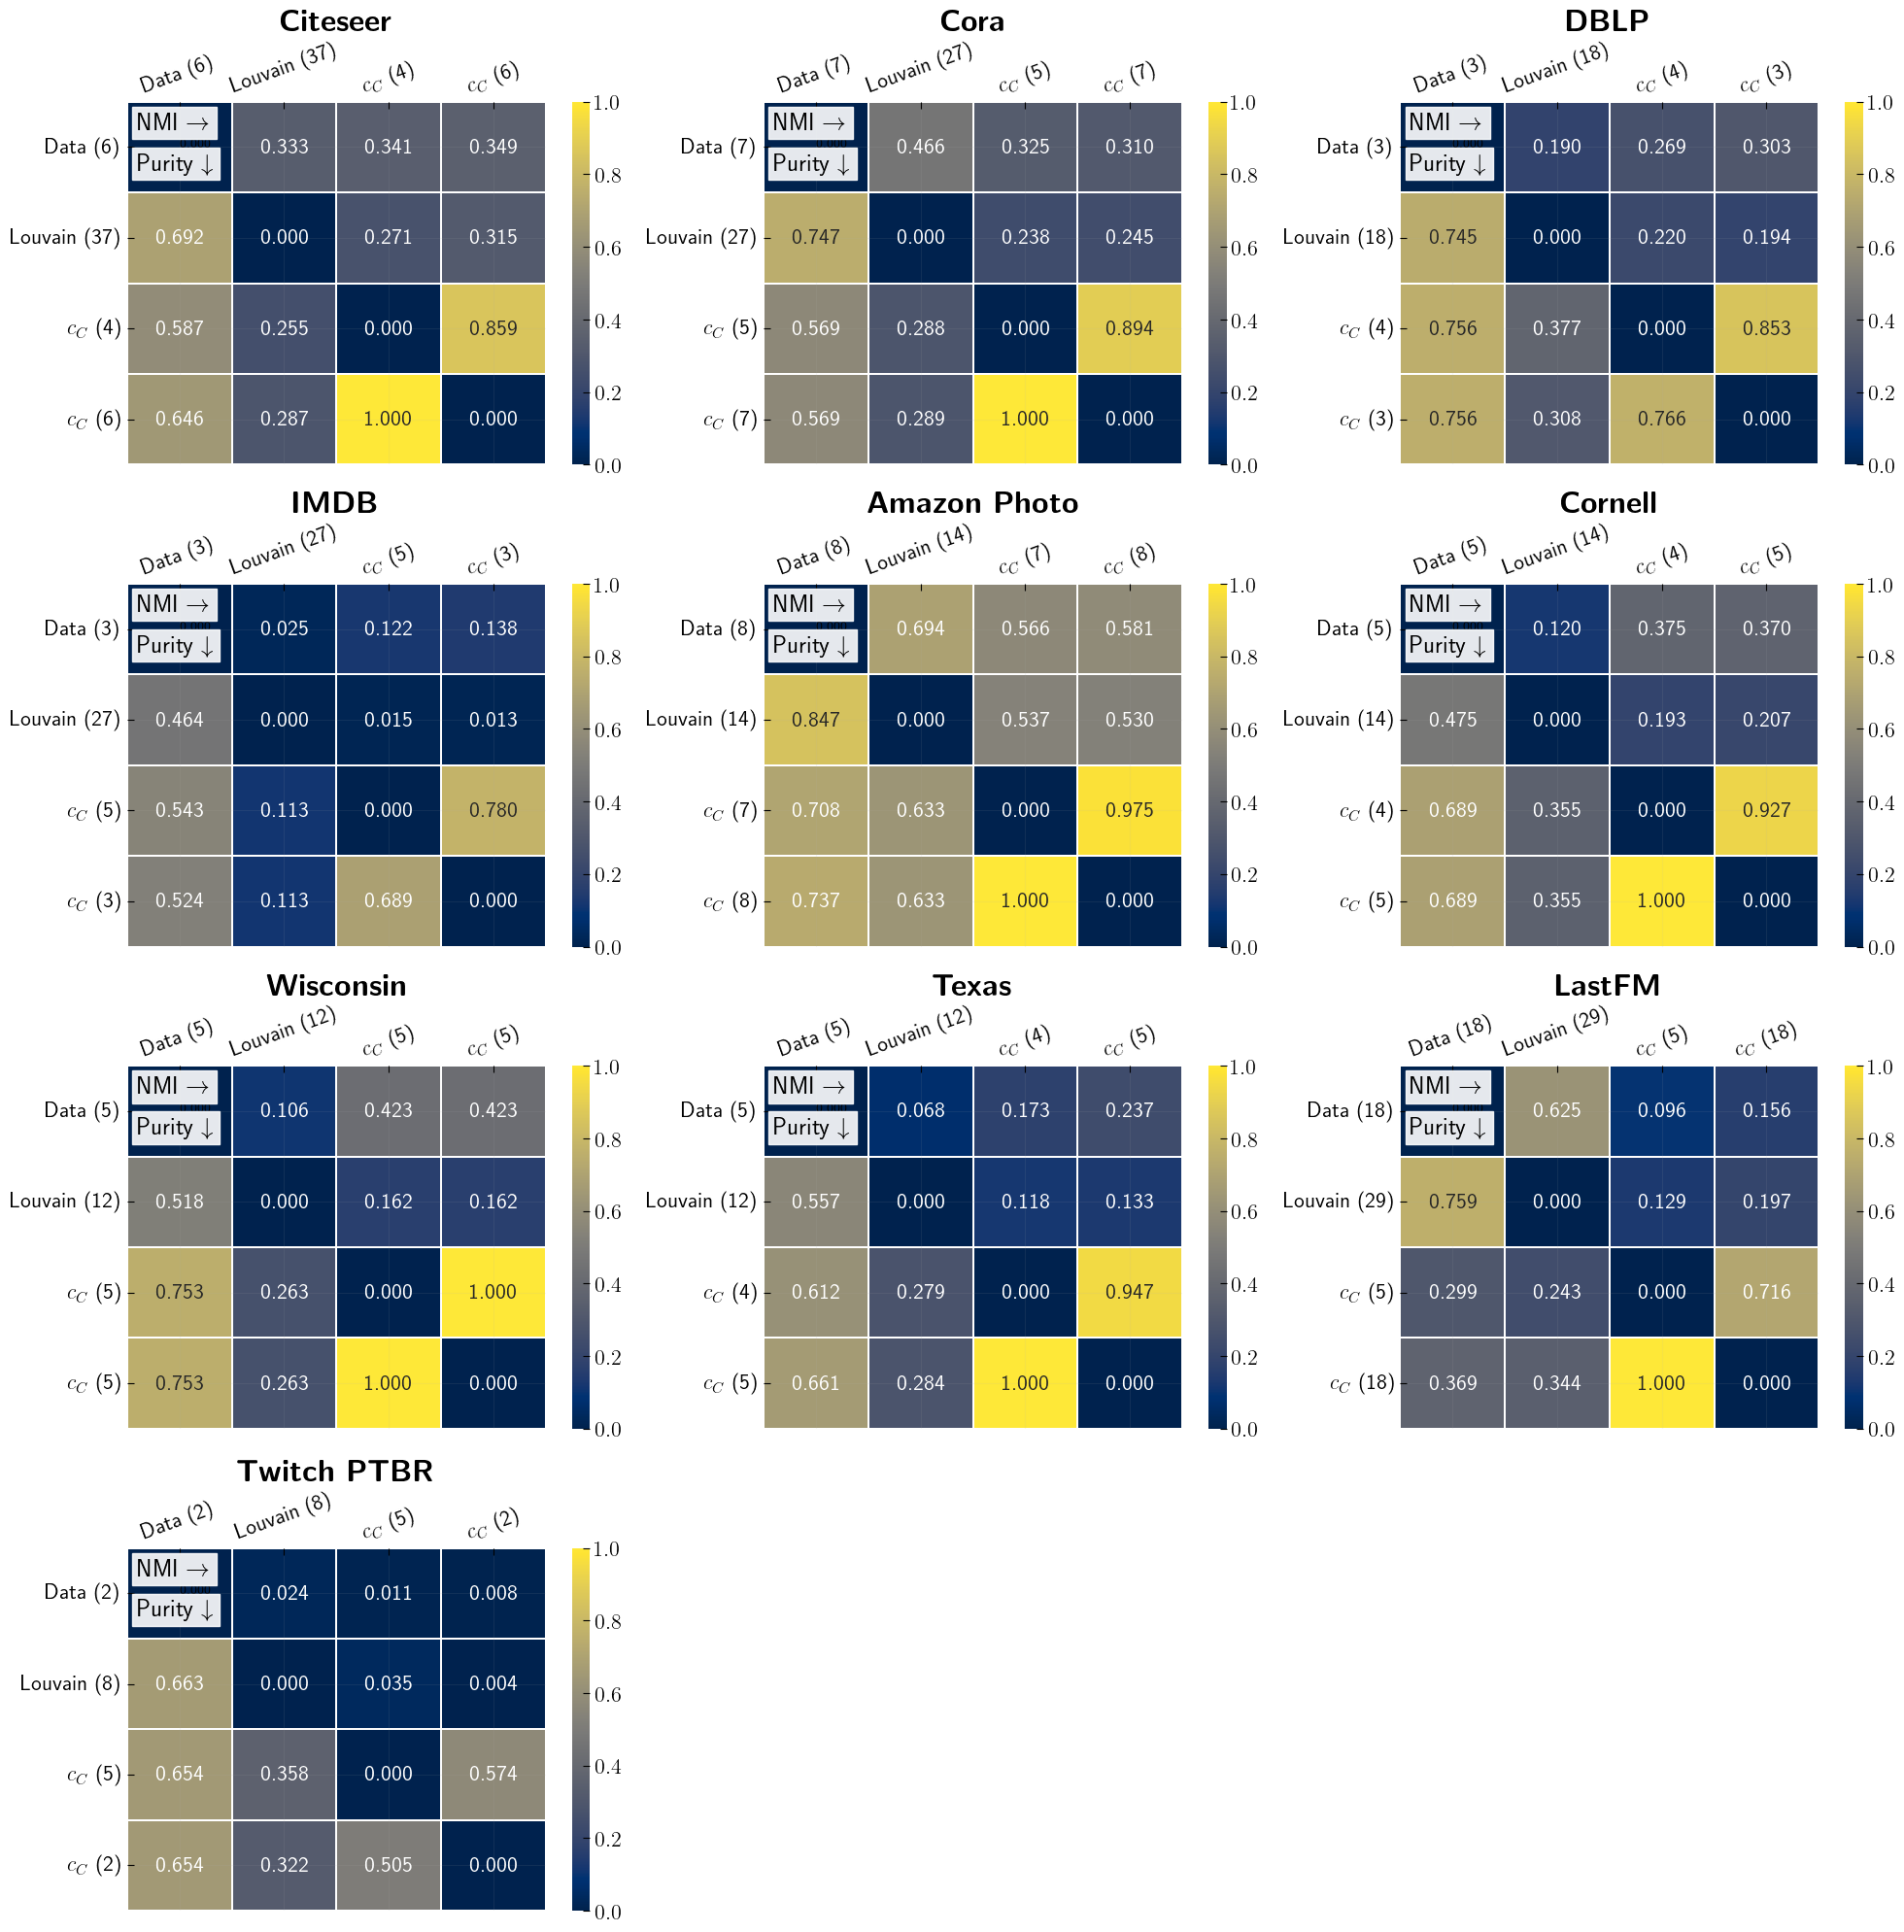

time: 12.2 s (started: 2024-01-10 12:45:42 +01:00)


In [20]:
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plot_overlapping_heatmap(citeseer_only_umap, 'Citeseer')

plt.subplot(4, 3, 2)
plot_overlapping_heatmap(cora_only_umap, 'Cora')

plt.subplot(4, 3, 3)
plot_overlapping_heatmap(dblp_only_umap, 'DBLP')

plt.subplot(4, 3, 4)
plot_overlapping_heatmap(imdb_only_umap, 'IMDB')

plt.subplot(4, 3, 5)
plot_overlapping_heatmap(amazon_photo_only_umap, 'Amazon Photo')

plt.subplot(4, 3, 6)
plot_overlapping_heatmap(cornell_only_umap, 'Cornell')

plt.subplot(4, 3, 7)
plot_overlapping_heatmap(wisconsin_only_umap, 'Wisconsin')

plt.subplot(4, 3, 8)
plot_overlapping_heatmap(texas_only_umap, 'Texas')

plt.subplot(4, 3, 9)
plot_overlapping_heatmap(lastfm_only_umap, 'LastFM')

plt.subplot(4, 3, 10)
plot_overlapping_heatmap(twitch_ptbr_only_umap, 'Twitch PTBR')

plt.tight_layout()

In [24]:
import matplotlib as mpl

def create_label_overlapping_matrix_with_random(df, niter=100):
    mat_nmi = np.zeros((4, 4))
    mat_purity = np.zeros((4, 4))
    mat_nmi_random = np.zeros((4, 4))
    mat_purity_random = np.zeros((4, 4))
    
    # 1 - true label
    # 2 - Louvain label
    # 3 - UMAP labels (the number of clusters was found using silhouette score)
    # 4 - UMAP labels (with the same number of clusters as in data)

    mat_nmi[0, 1] = compute_nmi(df['encoded_label'], df['label_louvain'])
    mat_nmi[0, 2] = compute_nmi(df['encoded_label'], df['label_clustering_find_k'])
    mat_nmi[0, 3] = compute_nmi(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_nmi[1, 2] = compute_nmi(df['label_louvain'], df['label_clustering_find_k'])
    mat_nmi[1, 3] = compute_nmi(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_nmi[2, 3] = compute_nmi(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    
    mat_nmi_random[0, 1] = np.mean([compute_nmi(df['encoded_label'], np.random.permutation(df['label_louvain'])) for _ in range(niter)])
    mat_nmi_random[0, 2] = np.mean([compute_nmi(df['encoded_label'], np.random.permutation(df['label_clustering_find_k'])) for _ in range(niter)])
    mat_nmi_random[0, 3] = np.mean([compute_nmi(df['encoded_label'], np.random.permutation(df['label_clustering_fixed_k'])) for _ in range(niter)])
    mat_nmi_random[1, 2] = np.mean([compute_nmi(df['label_louvain'], np.random.permutation(df['label_clustering_find_k'])) for _ in range(niter)])
    mat_nmi_random[1, 3] = np.mean([compute_nmi(df['label_louvain'], np.random.permutation(df['label_clustering_fixed_k'])) for _ in range(niter)])
    mat_nmi_random[2, 3] = np.mean([compute_nmi(df['label_clustering_find_k'], np.random.permutation(df['label_clustering_fixed_k'])) for _ in range(niter)])
    
    mat_purity[0, 1] = purity_score(df['encoded_label'], df['label_louvain'])
    mat_purity[0, 2] = purity_score(df['encoded_label'], df['label_clustering_find_k'])
    mat_purity[0, 3] = purity_score(df['encoded_label'], df['label_clustering_fixed_k'])
    mat_purity[1, 2] = purity_score(df['label_louvain'], df['label_clustering_find_k'])
    mat_purity[1, 3] = purity_score(df['label_louvain'], df['label_clustering_fixed_k'])
    mat_purity[2, 3] = purity_score(df['label_clustering_find_k'], df['label_clustering_fixed_k'])

    mat_purity_random[0, 1] = purity_score(df['encoded_label'], np.random.permutation(df['label_louvain']))
    mat_purity_random[0, 2] = purity_score(df['encoded_label'], np.random.permutation(df['label_clustering_find_k']))
    mat_purity_random[0, 3] = purity_score(df['encoded_label'], np.random.permutation(df['label_clustering_fixed_k']))
    mat_purity_random[1, 2] = purity_score(df['label_louvain'], np.random.permutation(df['label_clustering_find_k']))
    mat_purity_random[1, 3] = purity_score(df['label_louvain'], np.random.permutation(df['label_clustering_fixed_k']))
    mat_purity_random[2, 3] = purity_score(df['label_clustering_find_k'], np.random.permutation(df['label_clustering_fixed_k']))
    
    return mat_nmi, mat_purity, mat_nmi_random, mat_purity_random


def plot_overlapping_heatmap_with_random(df, title):
    m1, m2, m1_rand, m2_rand = create_label_overlapping_matrix_with_random(df)
    m = m1 + m2.T
    m_rand = m1_rand + m2_rand.T
    
    m_str = np.around(m, decimals=3).astype(str)
    m_rand_str = np.around(m_rand, decimals=3).astype(str)
    left_bracket = np.full((4, 4), '(')
    right_bracket = np.full((4, 4), ')')
    next_line = np.full((4, 4), '\n')
    
    non_significant = np.where(m_rand >= m) # when correlation is smaller than random case
    star = np.full((4, 4), r'$^*$')
    star[non_significant] = ''

    m_str = np.char.add(m_str, star)
    m_str = np.char.add(m_str, next_line)
    m_str = np.char.add(m_str, left_bracket)
    m_str = np.char.add(m_str, m_rand_str)
    m_str = np.char.add(m_str, right_bracket)
    np.fill_diagonal(m_str, '')

    ax = sns.heatmap(m, annot=m_str, vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis', fmt='', cbar=False, square=True)    
    
    cmap1 = mpl.colors.ListedColormap(['black'])
    sns.heatmap(m, mask=(m != 0), cmap=cmap1, cbar=False, ax=ax)
    
    
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Class ({len(np.unique(df['label']))})", 
                   f"Topology ({len(np.unique(df['label_louvain']))})", 
                   f"Features ({len(np.unique(df['label_clustering_find_k']))})",
                   f"Features ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=0)

    ax.set_xticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Class ({len(np.unique(df['label']))})", 
                   f"Topology ({len(np.unique(df['label_louvain']))})", 
                   f"Features ({len(np.unique(df['label_clustering_find_k']))})",
                   f"Features ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=20)
    # The number of clusters is shown in brackets
    
    ax.get_children()[1].update_from(ax.text(0.5, 0.5, ''))
    ax.text(0.09, 0.3, r'NMI $\rightarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.text(0.08, 0.75, r'Purity $\downarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)
    
    
    
def plot_overlapping_heatmap_with_random_only_nmi(df, title):
    m1, m2, m1_rand, m2_rand = create_label_overlapping_matrix_with_random(df)
    m = m1
    m_rand = m1_rand
    
    m_str = np.around(m, decimals=3).astype(str)
    m_rand_str = np.around(m_rand, decimals=3).astype(str)
    left_bracket = np.full((4, 4), '(')
    right_bracket = np.full((4, 4), ')')
    next_line = np.full((4, 4), '\n')
    
    non_significant = np.where(m_rand >= m) # when correlation is smaller than random case
    star = np.full((4, 4), r'$^*$')
    star[non_significant] = ''

    m_str = np.char.add(m_str, star)
    m_str = np.char.add(m_str, next_line)
    m_str = np.char.add(m_str, left_bracket)
    m_str = np.char.add(m_str, m_rand_str)
    m_str = np.char.add(m_str, right_bracket)
    np.fill_diagonal(m_str, '')

    ax = sns.heatmap(m, annot=m_str, vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis', fmt='', cbar=False, square=True)    
    
    cmap1 = mpl.colors.ListedColormap(['white'])
    sns.heatmap(m, mask=(m != 0), cmap=cmap1, cbar=False, ax=ax)
    
    ax.set(xlabel="", ylabel="")
    ax.xaxis.tick_top()
    ax.yaxis.tick_right()
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], 
                  [f"Class ({len(np.unique(df['label']))})", 
                   f"Topology ({len(np.unique(df['label_louvain']))})", 
                   f"Features ({len(np.unique(df['label_clustering_find_k']))})",
                   f""],
                 rotation=0)
    ax.set_xticks([0.5, 1.5, 2.5, 3.5], 
                  [f"", 
                   f"Topology ({len(np.unique(df['label_louvain']))})", 
                   f"Features ({len(np.unique(df['label_clustering_find_k']))})",
                   f"Features ({len(np.unique(df['label_clustering_fixed_k']))})"],
                 rotation=20)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    
    # The number of clusters is shown in brackets
    ax.get_children()[1].update_from(ax.text(0.5, 0.5, ''))
    #ax.text(0.09, 0.3, r'NMI $\rightarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)
    #ax.text(0.08, 0.75, r'Purity $\downarrow$', bbox=dict(color='white', alpha=0.9), fontsize=18)

    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)
    ax.grid(False)

time: 4.35 ms (started: 2024-01-10 12:47:07 +01:00)


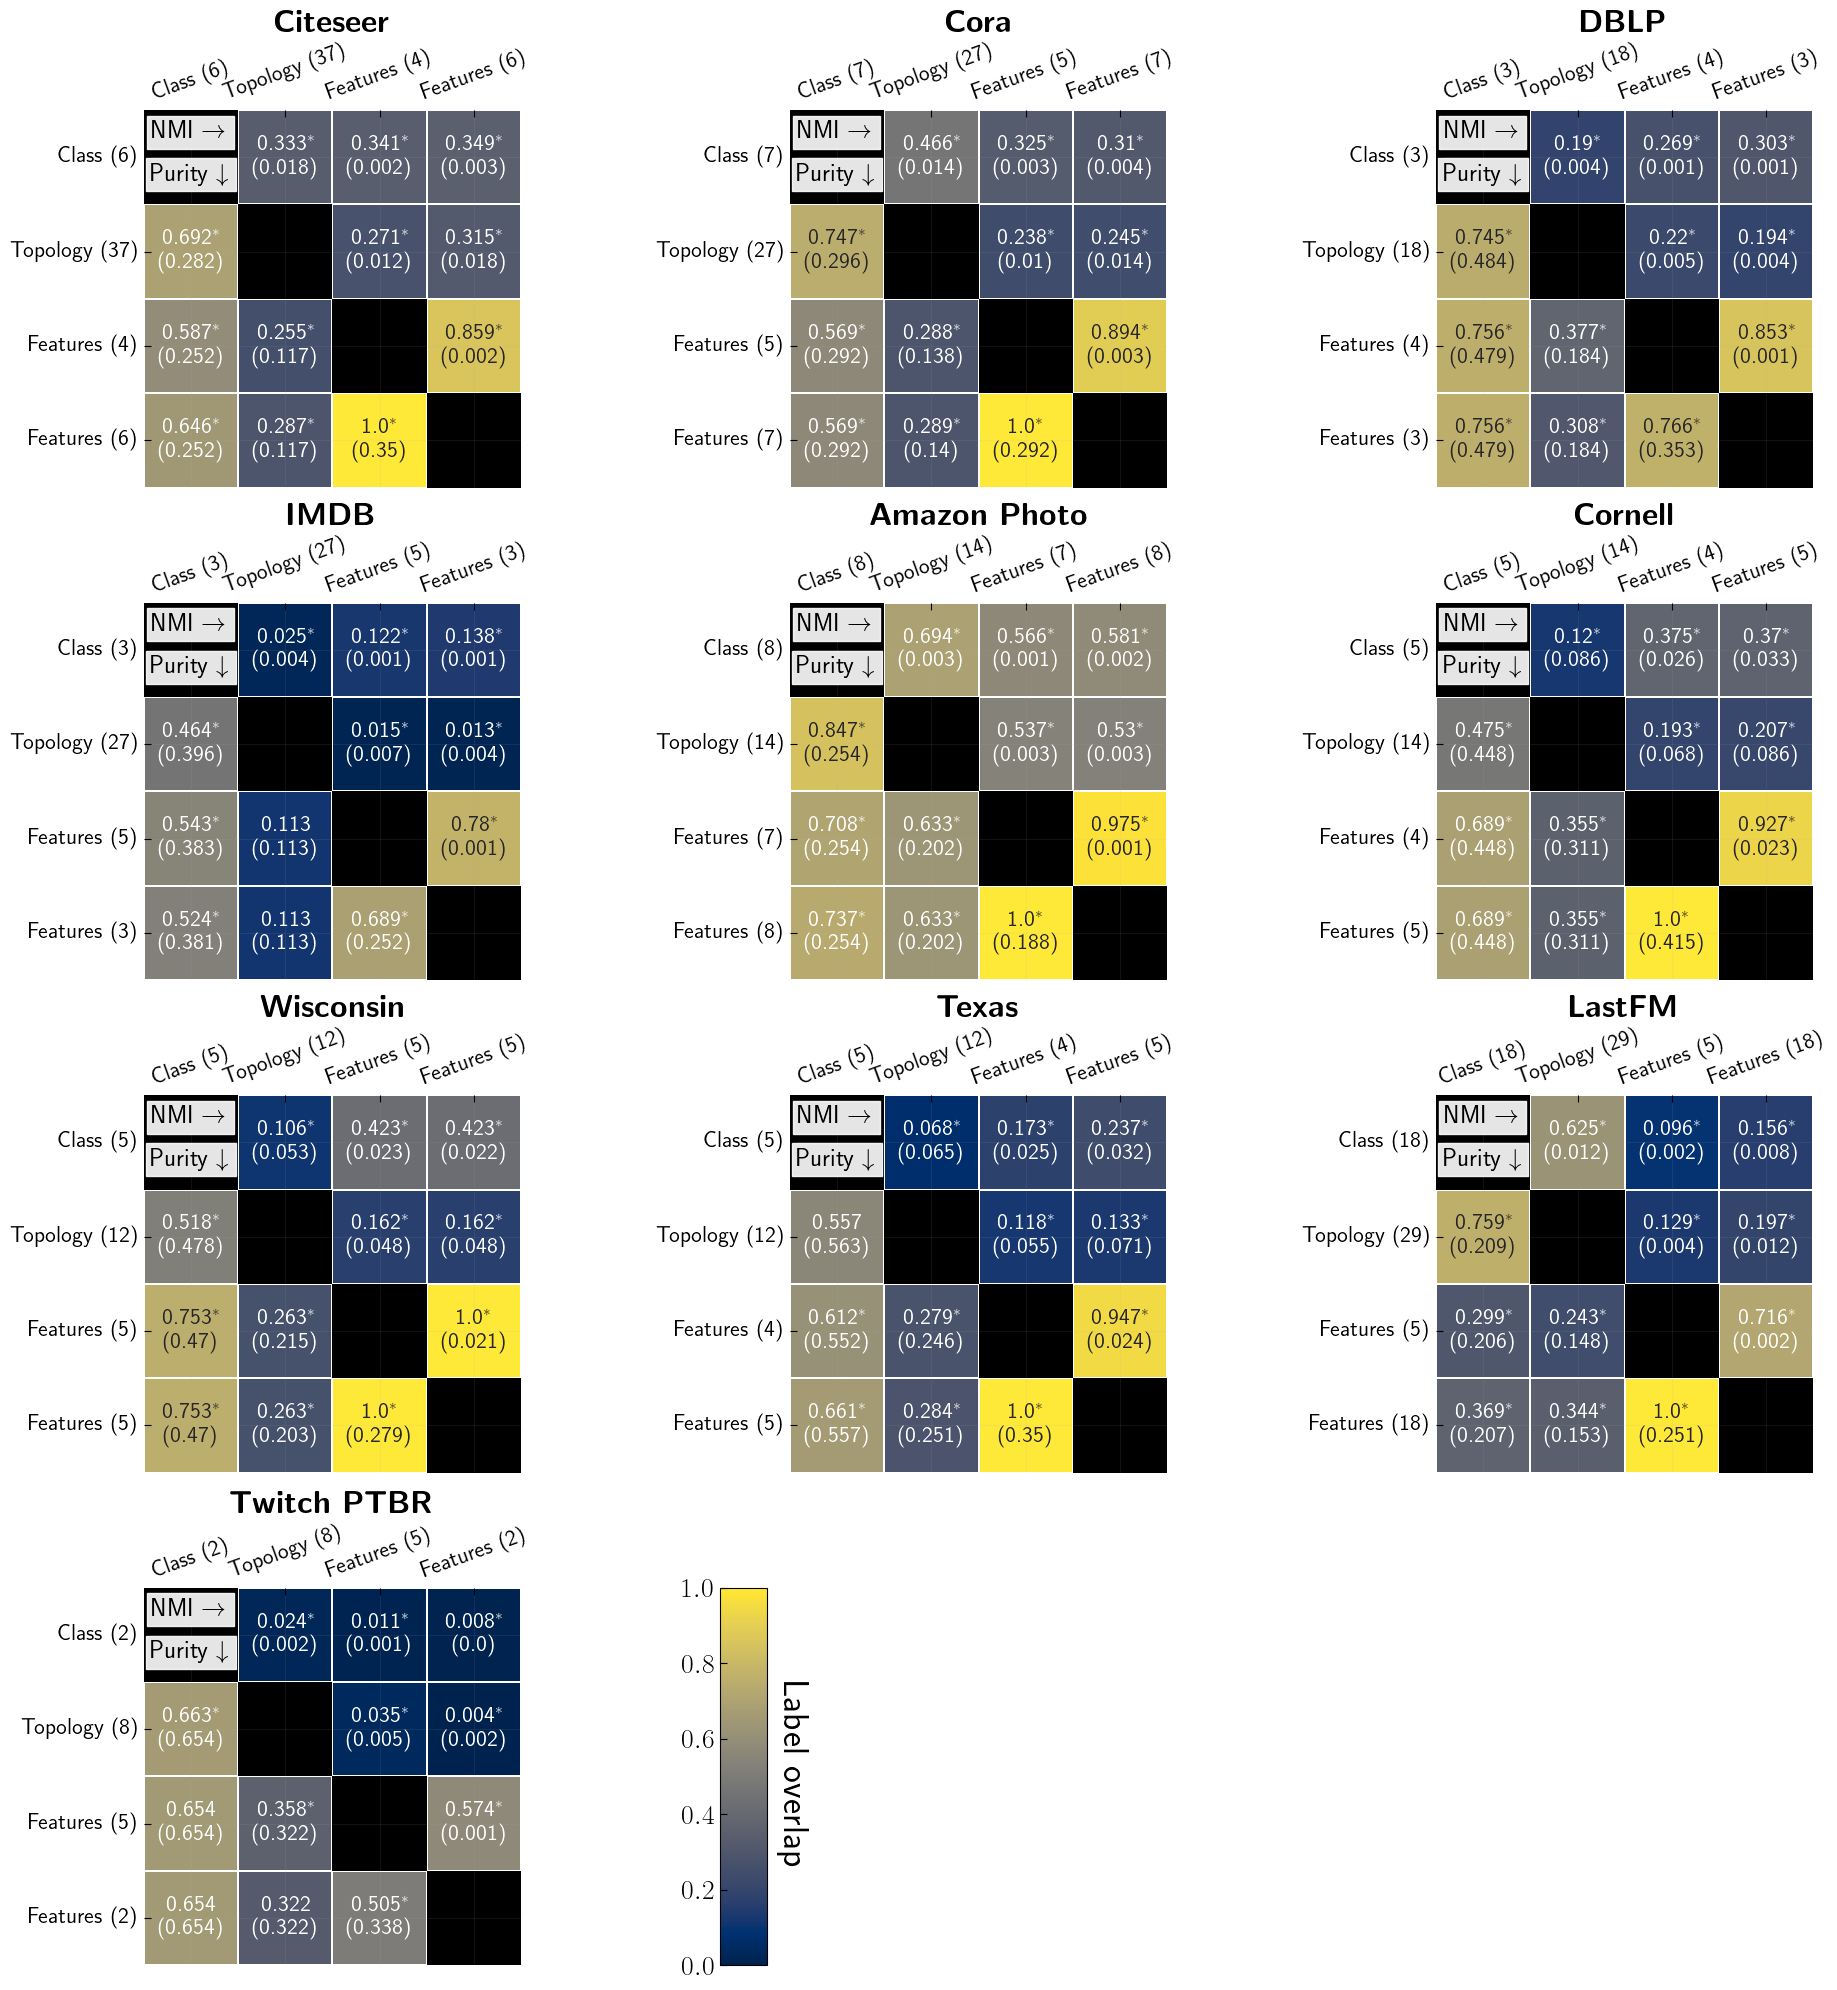

time: 25.7 s (started: 2024-01-10 12:46:01 +01:00)


In [22]:
plt.figure(figsize=(20, 20))

plt.subplot(4, 3, 1)
plot_overlapping_heatmap_with_random(citeseer_only_umap, 'Citeseer')

plt.subplot(4, 3, 2)
plot_overlapping_heatmap_with_random(cora_only_umap, 'Cora')

plt.subplot(4, 3, 3)
plot_overlapping_heatmap_with_random(dblp_only_umap, 'DBLP')

plt.subplot(4, 3, 4)
plot_overlapping_heatmap_with_random(imdb_only_umap, 'IMDB')

plt.subplot(4, 3, 5)
plot_overlapping_heatmap_with_random(amazon_photo_only_umap, 'Amazon Photo')

plt.subplot(4, 3, 6)
plot_overlapping_heatmap_with_random(cornell_only_umap, 'Cornell')

plt.subplot(4, 3, 7)
plot_overlapping_heatmap_with_random(wisconsin_only_umap, 'Wisconsin')

plt.subplot(4, 3, 8)
plot_overlapping_heatmap_with_random(texas_only_umap, 'Texas')

plt.subplot(4, 3, 9)
plot_overlapping_heatmap_with_random(lastfm_only_umap, 'LastFM')

plt.subplot(4, 3, 10)
plot_overlapping_heatmap_with_random(twitch_ptbr_only_umap, 'Twitch PTBR')

plt.subplot(4, 3, 11)
img = plt.imshow(np.array([[0,1]]), cmap='cividis')
img.set_visible(False)
clb = plt.colorbar(location='left',aspect=8)
clb.ax.tick_params(labelsize=20) 
clb.ax.set_ylabel('Label overlap', fontsize=26, rotation=270, labelpad=30)
clb.ax.yaxis.set_label_position("right")
# clb.ax.yaxis.tick_right()
plt.axis('off')

plt.tight_layout()

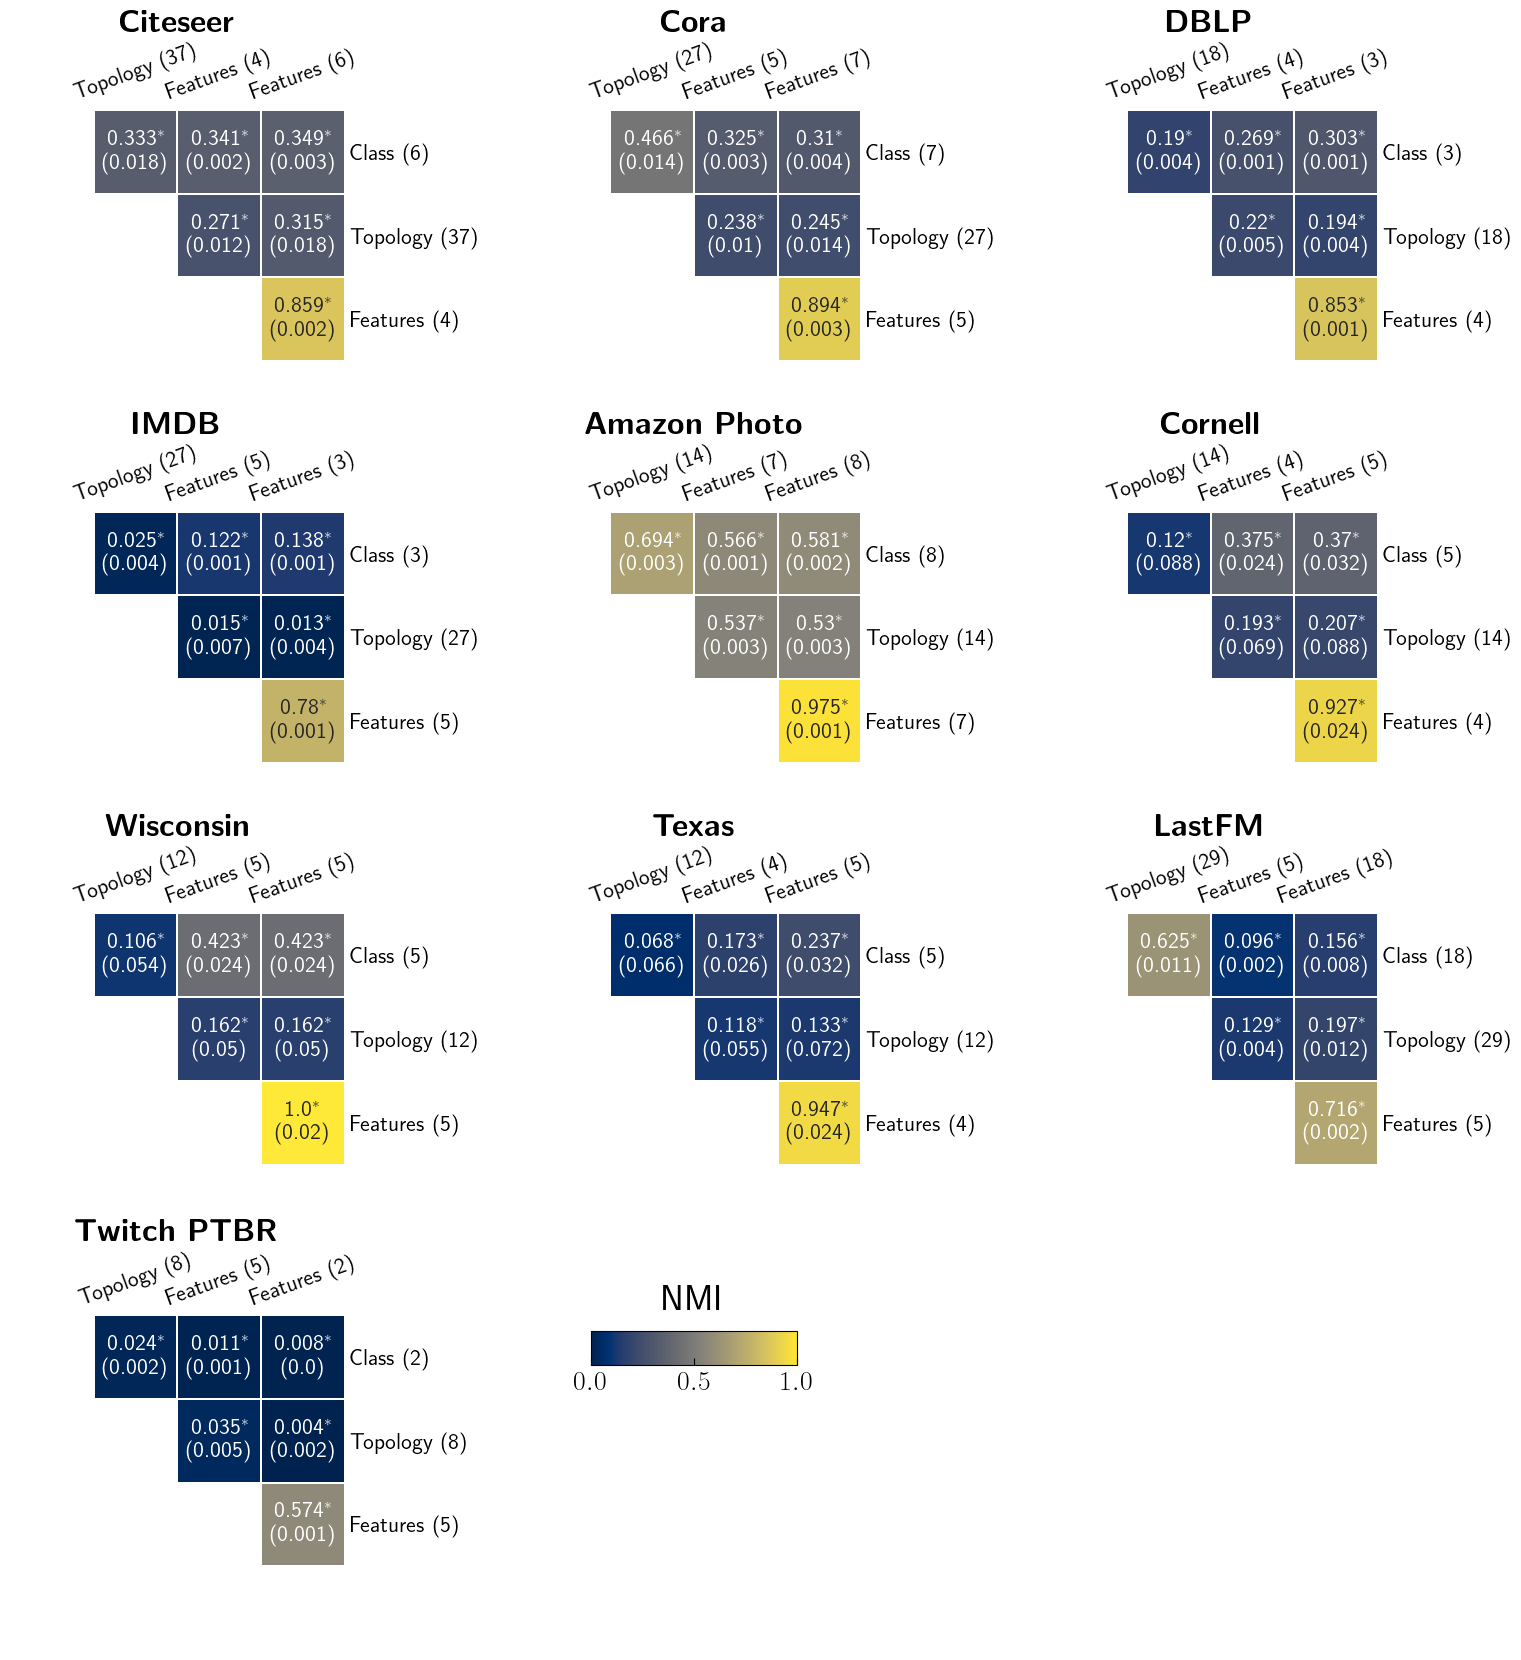

time: 19.5 s (started: 2024-01-10 12:48:27 +01:00)


In [27]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=0.2)

plt.subplot(4, 3, 1)
plot_overlapping_heatmap_with_random_only_nmi(citeseer_only_umap, 'Citeseer')

plt.subplot(4, 3, 2)
plot_overlapping_heatmap_with_random_only_nmi(cora_only_umap, 'Cora')

plt.subplot(4, 3, 3)
plot_overlapping_heatmap_with_random_only_nmi(dblp_only_umap, 'DBLP')

plt.subplot(4, 3, 4)
plot_overlapping_heatmap_with_random_only_nmi(imdb_only_umap, 'IMDB')

plt.subplot(4, 3, 5)
plot_overlapping_heatmap_with_random_only_nmi(amazon_photo_only_umap, 'Amazon Photo')

plt.subplot(4, 3, 6)
plot_overlapping_heatmap_with_random_only_nmi(cornell_only_umap, 'Cornell')

plt.subplot(4, 3, 7)
plot_overlapping_heatmap_with_random_only_nmi(wisconsin_only_umap, 'Wisconsin')

plt.subplot(4, 3, 8)
plot_overlapping_heatmap_with_random_only_nmi(texas_only_umap, 'Texas')

plt.subplot(4, 3, 9)
plot_overlapping_heatmap_with_random_only_nmi(lastfm_only_umap, 'LastFM')

plt.subplot(4, 3, 10)
plot_overlapping_heatmap_with_random_only_nmi(twitch_ptbr_only_umap, 'Twitch PTBR')

plt.subplot(4, 3, 11)
img = plt.imshow(np.array([[0, 1]]), cmap='cividis')
img.set_visible(False)
clb = plt.colorbar(location='top', aspect=6, shrink=0.4)
clb.ax.tick_params(labelsize=20)

# clb.ax.set_ylabel('NMI', fontsize=26, rotation=270, labelpad=30)
clb.ax.set_xlabel('NMI', fontsize=26, labelpad=15)
# clb.ax.yaxis.set_label_position("right")
clb.ax.xaxis.set_label_position("top")
clb.ax.xaxis.set_ticks_position('bottom')

# clb.ax.yaxis.tick_right()
plt.axis('off') 

# plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/nmi_upper_triangle_matrix_all.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/nmi_upper_triangle_matrix_all.jpg", dpi=300)
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/nmi_upper_triangle_matrix_all.eps")


# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/SI/plots/nmi_upper_triangle_matrix_all_average_random_tmp.pdf")
# After fixing the grid in Inkscape

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/nmi_upper_triangle_matrix_all_average_random_name_class.pdf")


In [28]:
def plot_correlation_triangle(df, ax, title=None):
    nmi_data_louvain = compute_nmi(df['encoded_label'], df['label_louvain'])
    nmi_data_umap = compute_nmi(df['encoded_label'], df['label_clustering_find_k'])
    nmi_louvain_umap = compute_nmi(df['label_louvain'], df['label_clustering_find_k'])
    
    nmi_data_louvain_rand = compute_nmi(df['encoded_label'], np.random.permutation(df['label_louvain']))
    nmi_data_umap_rand = compute_nmi(df['encoded_label'], np.random.permutation(df['label_clustering_find_k']))
    nmi_louvain_umap_rand = compute_nmi(df['label_louvain'], np.random.permutation(df['label_clustering_find_k']))
        
    r1 = (0, 0)
    r2 = (0.5, 0.75)
    r3 = (1, 0)
    R = 0.24
    linewidth = 4
    circle_louvain = plt.Circle(r1, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)
    circle_data = plt.Circle(r2, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)
    circle_umap = plt.Circle(r3, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)

    ax.add_patch(circle_data)
    ax.add_patch(circle_louvain)
    ax.add_patch(circle_umap)

    ax.annotate(r"$\textbf{Topology}$", xy=r1, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    ax.annotate(r"$\textbf{Class}$", xy=r2, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    ax.annotate(r"$\textbf{Features}$", xy=r3, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    
    linewidth_scale = 30
    
    if nmi_data_louvain > nmi_data_louvain_rand:
        ax.text(0.08, 0.36, rf'{{{np.round(nmi_data_louvain, 3)}}}$^*$',fontsize=24, rotation=55)
        ax.plot([r1[0]+R/2, r2[0]-R/2], [r1[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:red', linewidth=linewidth_scale*nmi_data_louvain, zorder=1)
    else:
        ax.text(0.08, 0.36, np.round(nmi_data_louvain, 3), fontsize=24, rotation=55)
        ax.plot([r1[0]+R/2, r2[0]-R/2], [r1[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:red', linewidth=2,
               linestyle='--')
        
    if nmi_data_umap > nmi_data_umap_rand:
        ax.text(0.74, 0.33, rf'{{{np.round(nmi_data_umap, 3)}}}$^*$',fontsize=24, rotation=-55)
        ax.plot([r3[0]-R/2, r2[0]+R/2], [r3[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:blue', linewidth=linewidth_scale*nmi_data_umap, zorder=1)
    else:
        ax.text(0.74, 0.33, np.round(nmi_data_umap, 3),fontsize=24, rotation=-55)
        ax.plot([r3[0]-R/2, r2[0]+R/2], [r3[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:blue', linewidth=2,
               linestyle='--')
    
    if nmi_louvain_umap > nmi_louvain_umap_rand:
        ax.text(0.4, 0.05, rf'{{{np.round(nmi_louvain_umap, 3)}}}$^*$',fontsize=24)
        ax.plot([r1[0]+R, r3[0]-R], [0, 0], color='xkcd:green', linewidth=linewidth_scale*nmi_louvain_umap, zorder=1)
    else:
        ax.text(0.4, 0.05, np.round(nmi_louvain_umap, 3),fontsize=24)
        ax.plot([r1[0]+R, r3[0]-R], [0, 0], color='xkcd:green', linewidth=2, linestyle='--')
        

    if title is not None:
        ax.set_title(rf'\textbf{{{title}}}', fontsize=30)


    ax.axis('off')
    ax.set_aspect('equal')
    ax.autoscale_view()

time: 2.89 ms (started: 2024-01-10 12:55:14 +01:00)


In [29]:
custom_preamble = {                                                                          
    "text.latex.preamble":                                                                   
        r"\usepackage{amsmath}" # for the align, center,... environment
        ,
    }   
plt.rcParams.update(custom_preamble)  
plt.rcParams['text.latex.preamble'] = r'\centering'

def plot_correlation_triangle_with_random_sigma(df, ax, title=None, niter=100):
    nmi_data_louvain = compute_nmi(df['encoded_label'], df['label_louvain'])
    nmi_data_umap = compute_nmi(df['encoded_label'], df['label_clustering_find_k'])
    nmi_louvain_umap = compute_nmi(df['label_louvain'], df['label_clustering_find_k'])
    
    
    nmi_data_louvain_rand = [compute_nmi(df['encoded_label'], np.random.permutation(df['label_louvain'])) for _ in range(niter)]
    nmi_data_louvain_rand_mean = np.mean(nmi_data_louvain_rand)
    nmi_data_louvain_rand_std = np.std(nmi_data_louvain_rand)
    nmi_data_louvain_idx = (nmi_data_louvain - nmi_data_louvain_rand_mean) / nmi_data_louvain_rand_std
    
    nmi_data_umap_rand = [compute_nmi(df['encoded_label'], np.random.permutation(df['label_clustering_find_k'])) for _ in range(niter)]
    nmi_data_umap_rand_mean = np.mean(nmi_data_umap_rand)
    nmi_data_umap_rand_std = np.std(nmi_data_umap_rand)
    nmi_data_umap_idx = (nmi_data_umap - nmi_data_umap_rand_mean) / nmi_data_umap_rand_std
    
    nmi_louvain_umap_rand = [compute_nmi(df['label_louvain'], np.random.permutation(df['label_clustering_find_k'])) for _ in range(niter)]
    nmi_louvain_umap_rand_mean = np.mean(nmi_louvain_umap_rand)
    nmi_louvain_umap_rand_std = np.std(nmi_louvain_umap_rand)
    nmi_louvain_umap_idx = (nmi_louvain_umap - nmi_louvain_umap_rand_mean) / nmi_louvain_umap_rand_std
       
    r1 = (0, 0)
    r2 = (0.5, 0.75)
    r3 = (1, 0)
    R = 0.24
    linewidth = 4
    circle_louvain = plt.Circle(r1, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)
    circle_data = plt.Circle(r2, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)
    circle_umap = plt.Circle(r3, R, linewidth=linewidth, edgecolor='black', facecolor='white', zorder=2)

    ax.add_patch(circle_data)
    ax.add_patch(circle_louvain)
    ax.add_patch(circle_umap)

    ax.annotate(r"$\textbf{Topology}$", xy=r1, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    ax.annotate(r"$\textbf{Class}$", xy=r2, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    ax.annotate(r"$\textbf{Features}$", xy=r3, fontsize=25, verticalalignment="center", horizontalalignment="center", zorder=3)
    
    linewidth_scale = 30
    
    ax.text(0, 0.40, rf'\textbf{{{{{np.round(nmi_data_louvain, 3)}}}}} \\ ({{{np.round(nmi_data_louvain_idx, 1)}}})',fontsize=24, rotation=55)
    ax.plot([r1[0]+R/2, r2[0]-R/2], [r1[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:red', linewidth=linewidth_scale*nmi_data_louvain, zorder=1)

    ax.text(0.71, 0.39, rf'\textbf{{{{{np.round(nmi_data_umap, 3)}}}}} \\ ({{{np.round(nmi_data_umap_idx, 1)}}})',fontsize=24, rotation=-55)
    ax.plot([r3[0]-R/2, r2[0]+R/2], [r3[1]+np.sqrt(3)/2*R, r2[1]-np.sqrt(3)/2*R], color='xkcd:blue', linewidth=linewidth_scale*nmi_data_umap, zorder=1)
    
    ax.text(0.36, 0.14, rf'\textbf{{{{{np.round(nmi_louvain_umap, 3)}}}}} \\ ({{{np.round(nmi_louvain_umap_idx, 1)}}})',fontsize=24)
    ax.plot([r1[0]+R, r3[0]-R], [0, 0], color='xkcd:green', linewidth=linewidth_scale*nmi_louvain_umap, zorder=1)
    
    if title is not None:
        ax.set_title(rf'\textbf{{{title}}}', fontsize=30)


    ax.axis('off')
    ax.set_aspect('equal')
    ax.autoscale_view()

time: 4.05 ms (started: 2024-01-10 12:55:22 +01:00)


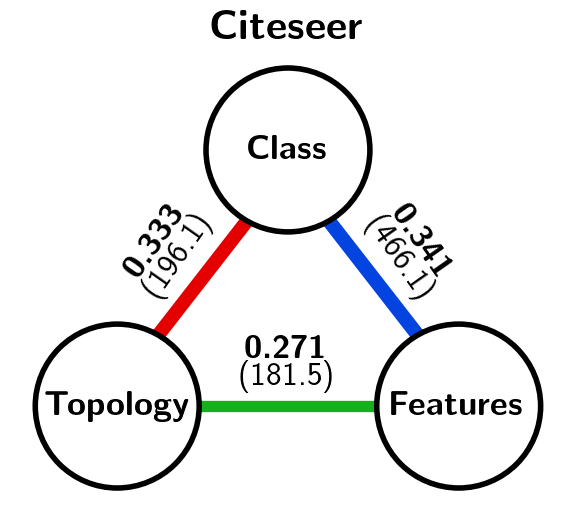

time: 2.05 s (started: 2024-01-10 12:55:23 +01:00)


In [30]:
fig, ax = plt.subplots()
plot_correlation_triangle_with_random_sigma(citeseer_only_umap, ax, 'Citeseer')

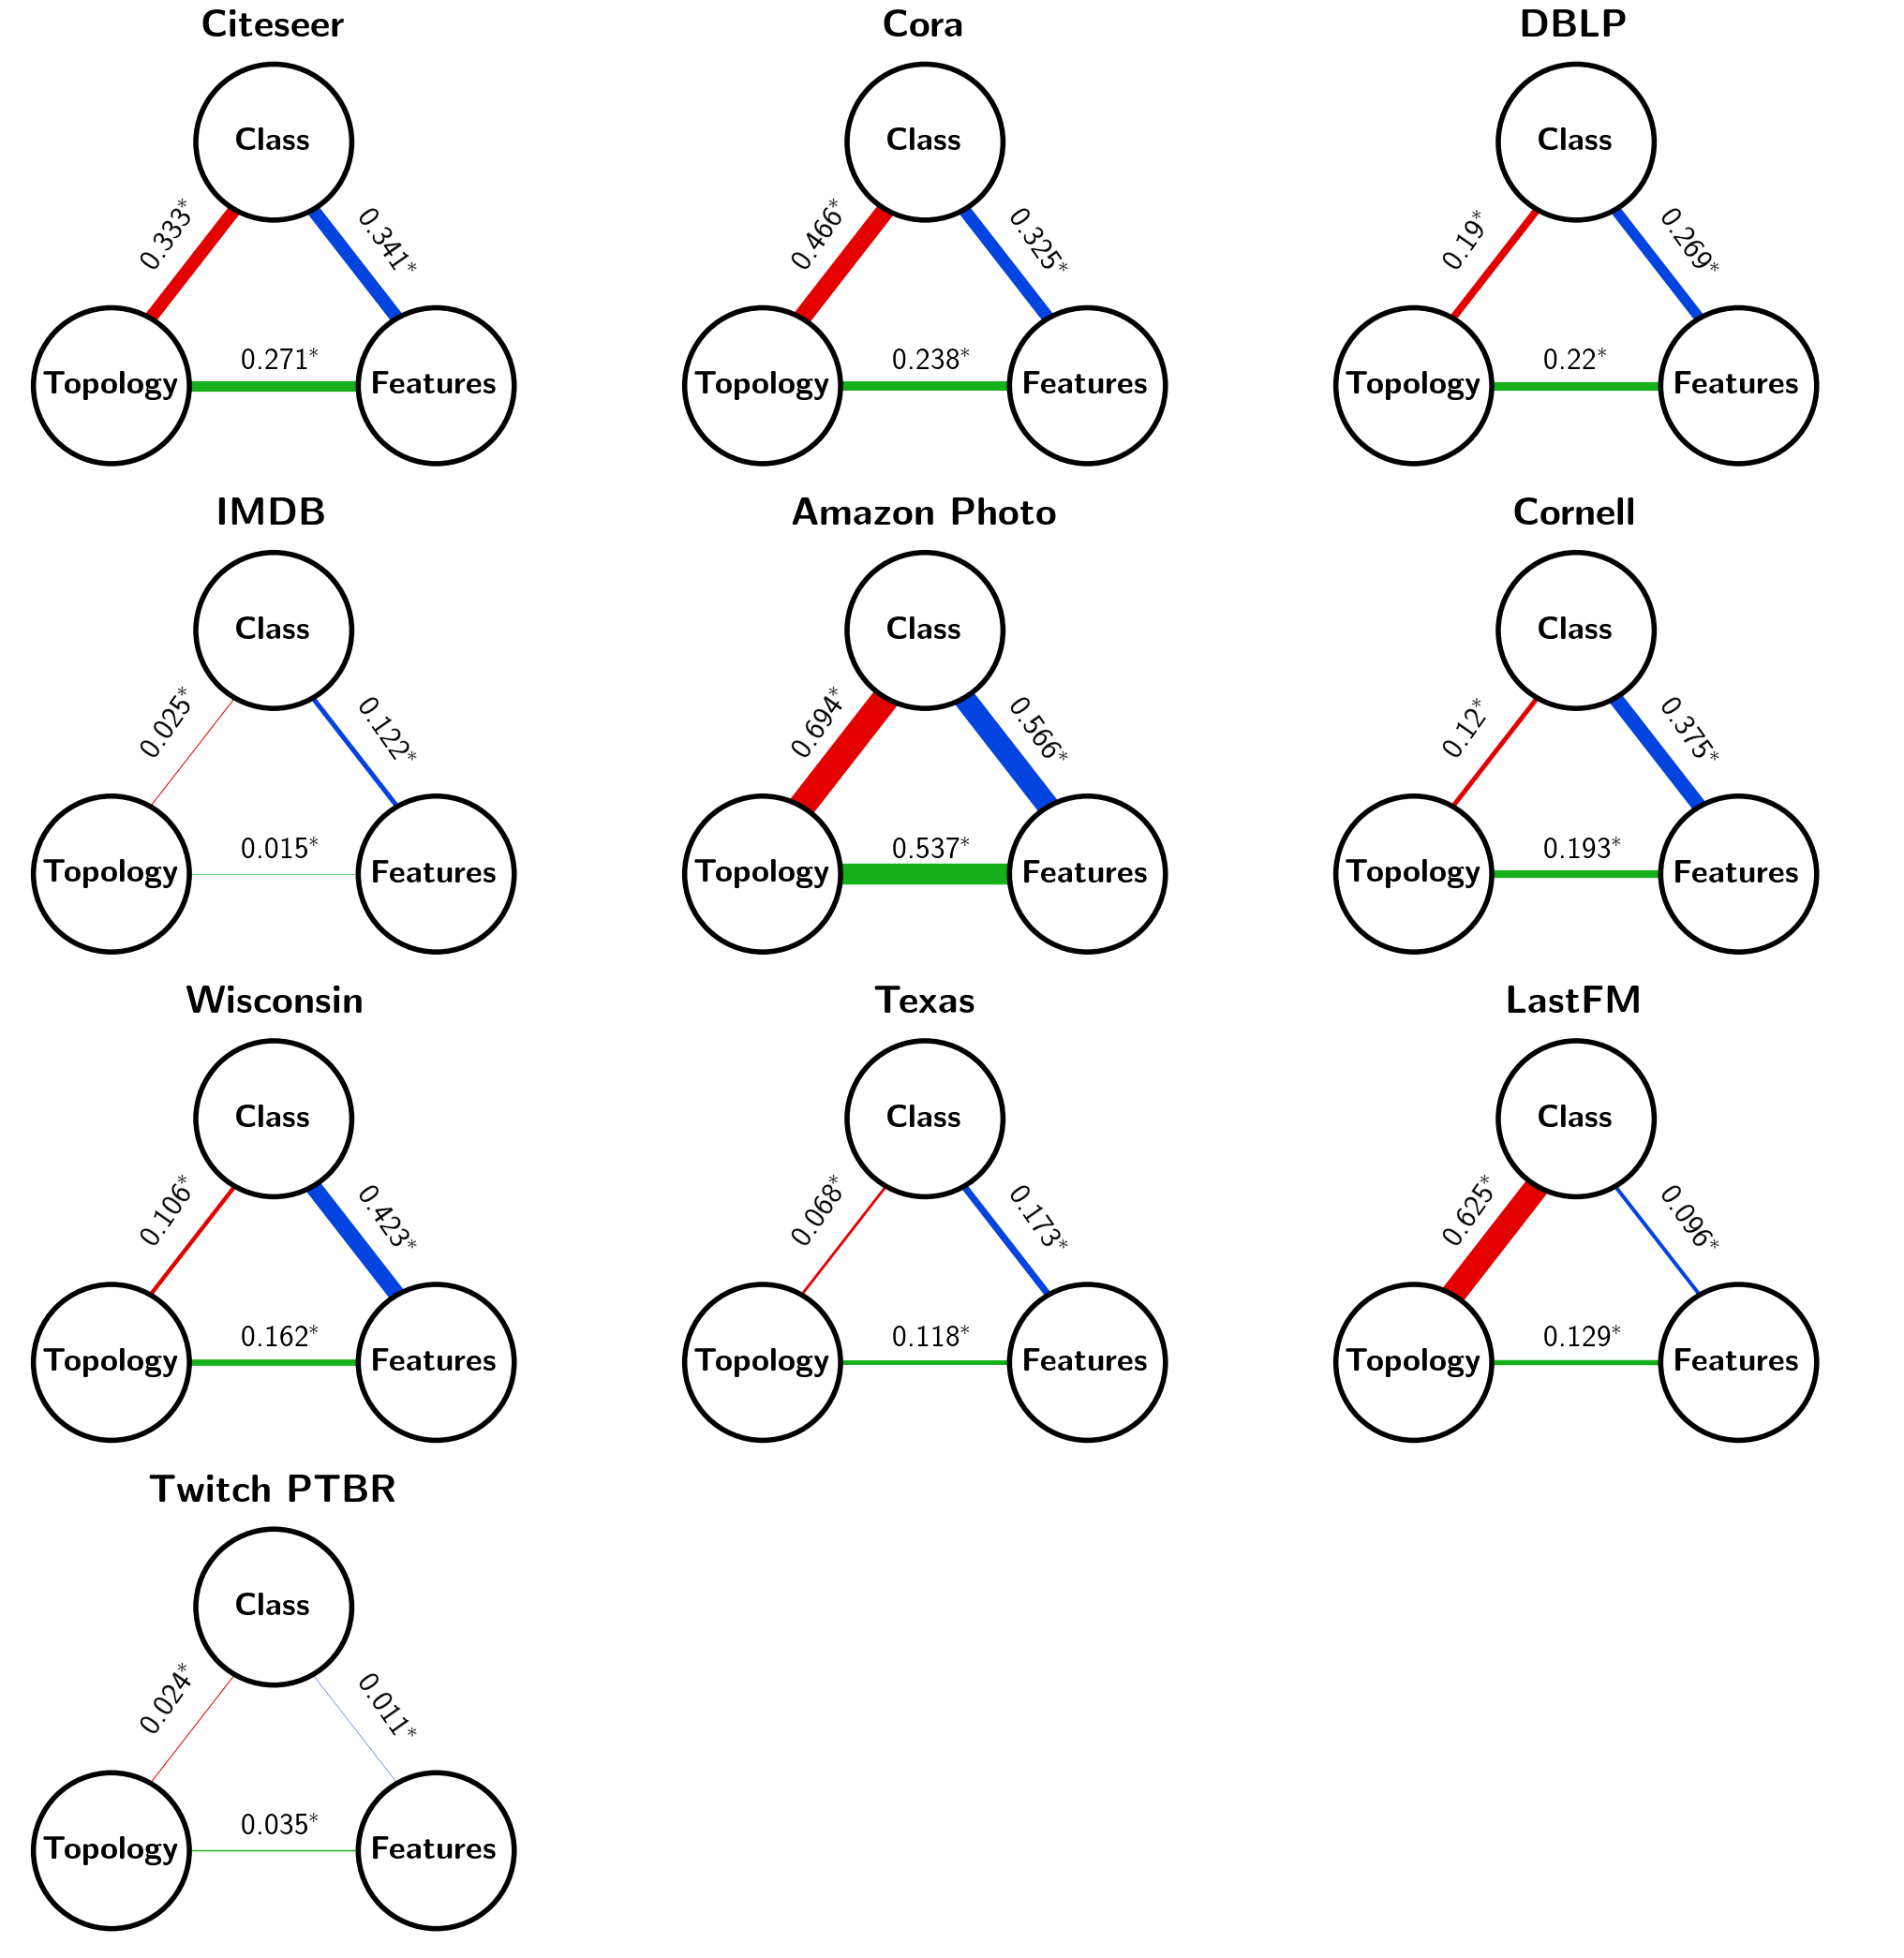

time: 11.2 s (started: 2024-01-10 12:55:30 +01:00)


In [31]:
fig, ax = plt.subplots(4, 3, figsize=(21, 21))
plot_correlation_triangle(citeseer_only_umap, ax[0][0], 'Citeseer')
plot_correlation_triangle(cora_only_umap, ax[0][1], 'Cora')
plot_correlation_triangle(dblp_only_umap, ax[0][2], 'DBLP')
plot_correlation_triangle(imdb_only_umap, ax[1][0], 'IMDB')
plot_correlation_triangle(amazon_photo_only_umap, ax[1][1], 'Amazon Photo')
plot_correlation_triangle(cornell_only_umap, ax[1][2], 'Cornell')
plot_correlation_triangle(wisconsin_only_umap, ax[2][0], 'Wisconsin')
plot_correlation_triangle(texas_only_umap, ax[2][1], 'Texas')
plot_correlation_triangle(lastfm_only_umap, ax[2][2], 'LastFM')
plot_correlation_triangle(twitch_ptbr_only_umap, ax[3][0], 'Twitch PTBR')
ax[3][1].axis('off')
ax[3][2].axis('off')


plt.tight_layout()

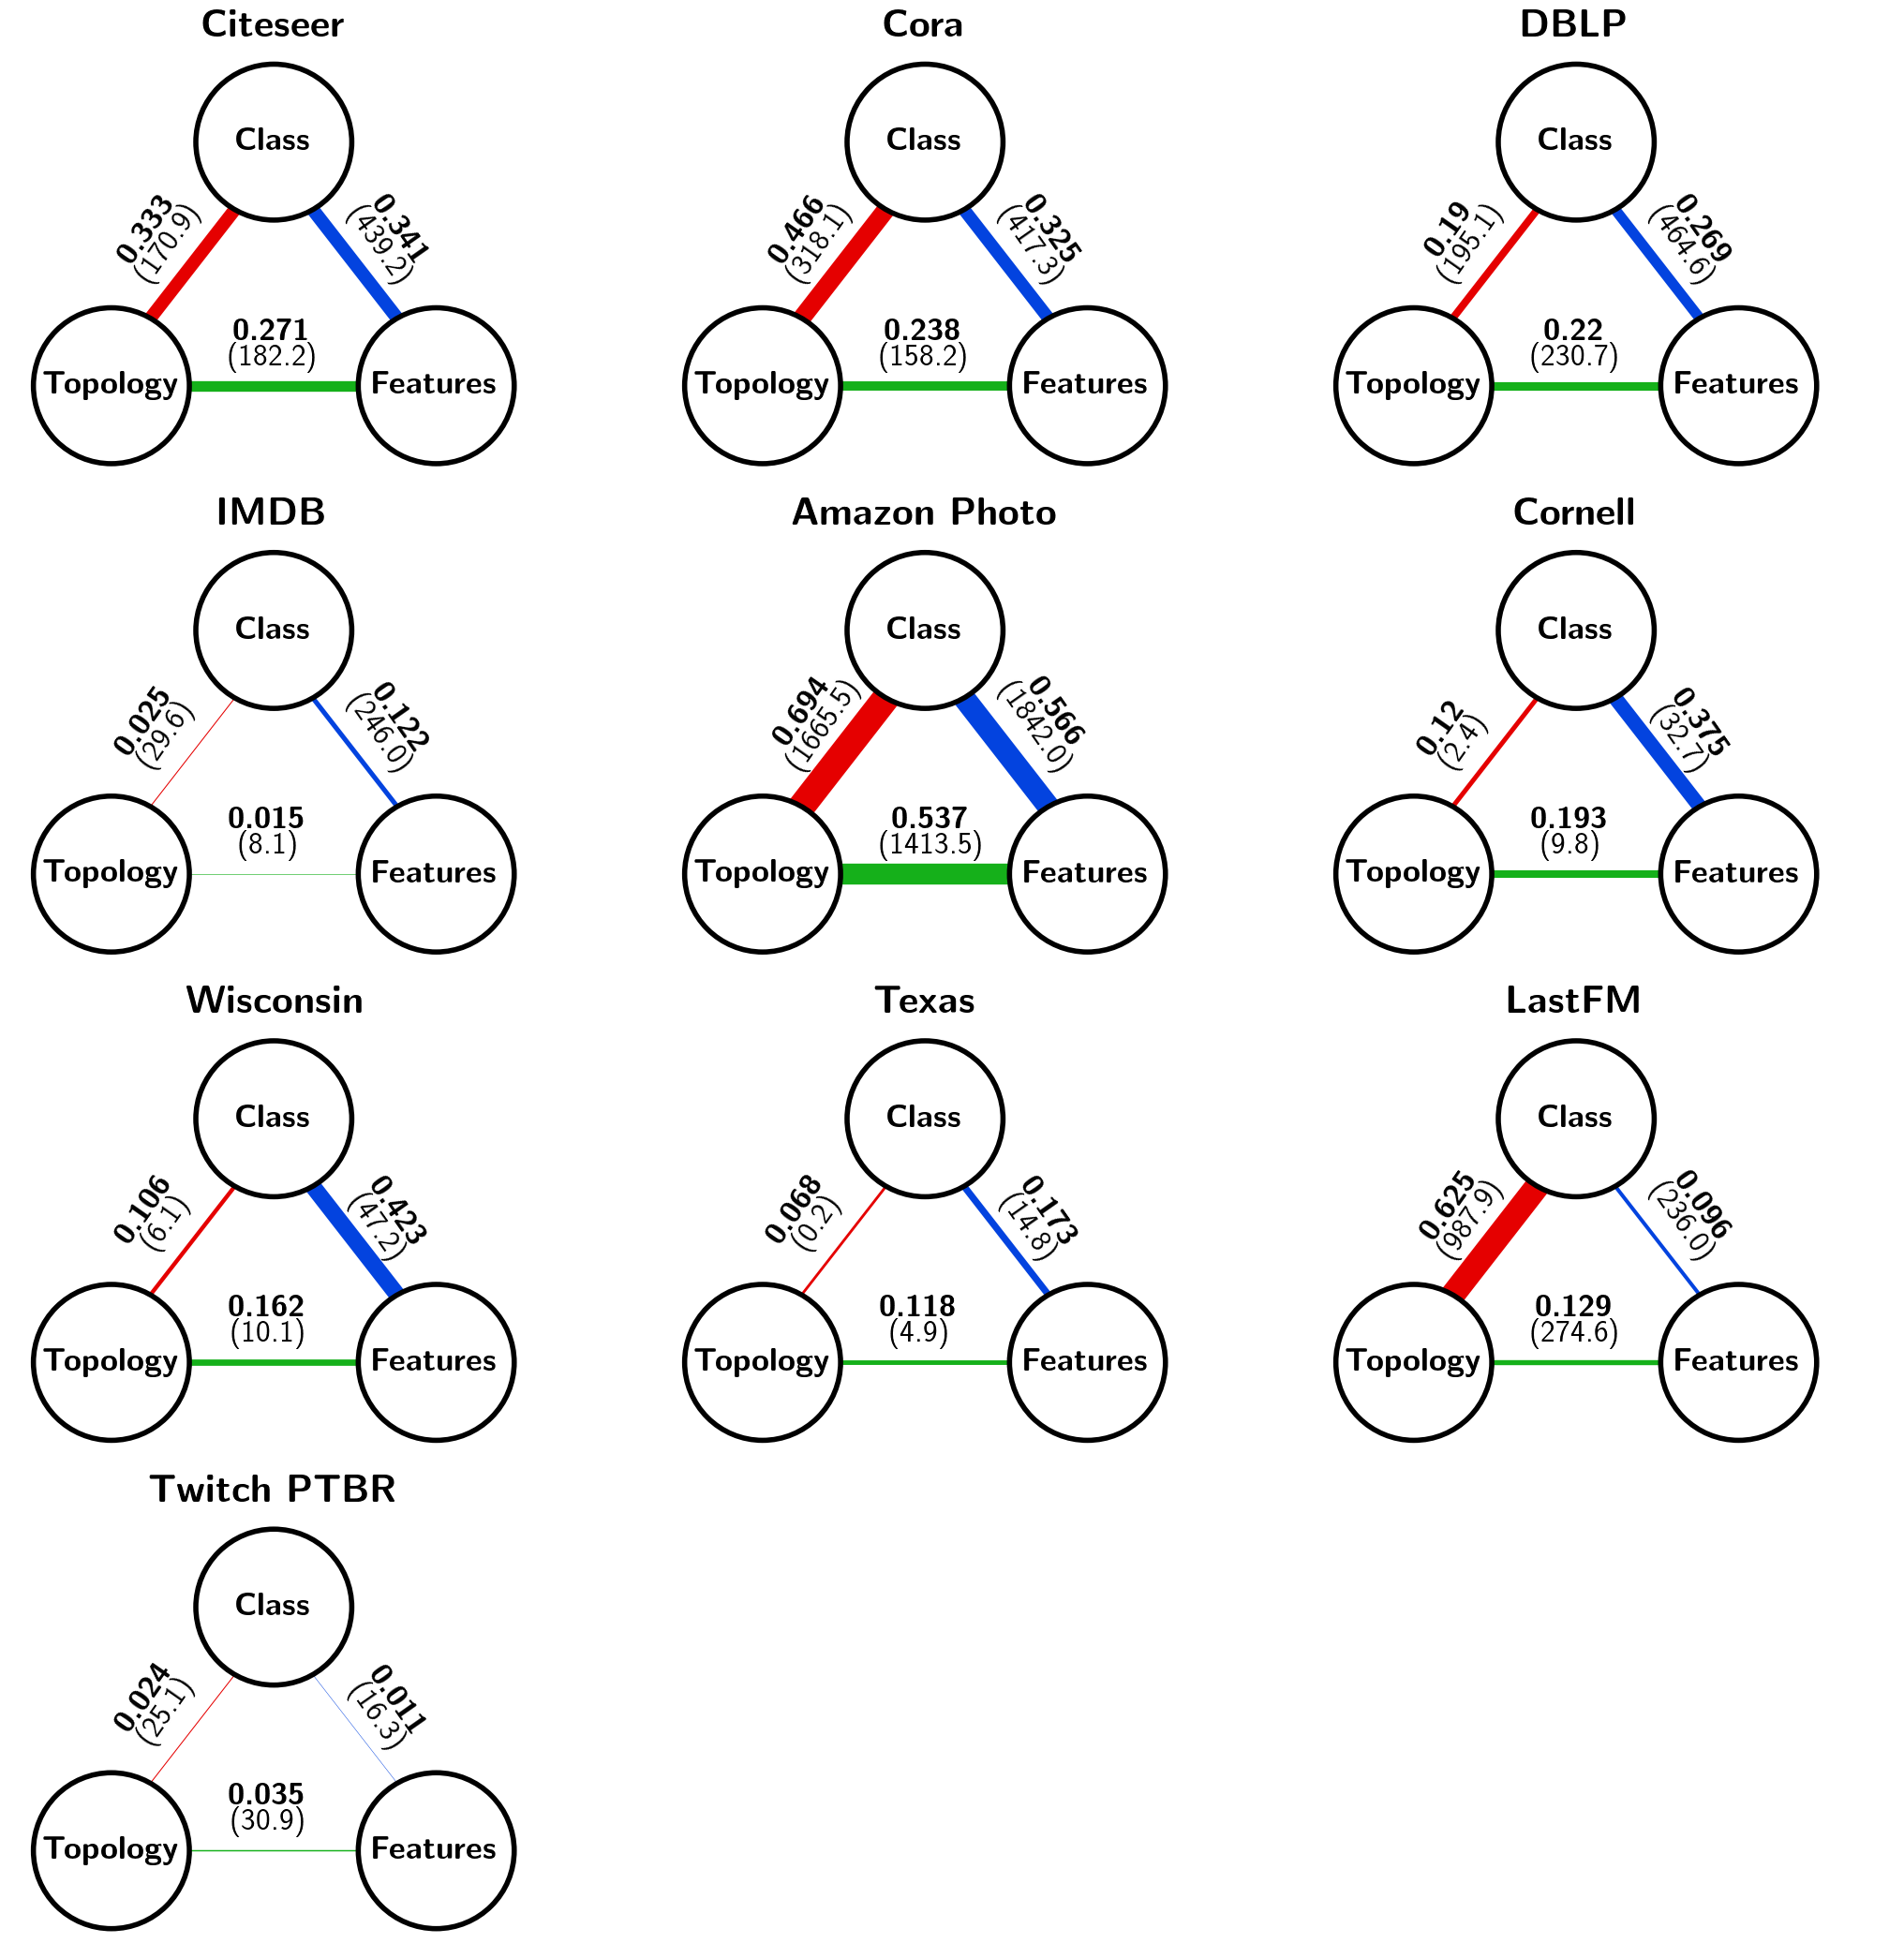

time: 16.5 s (started: 2024-01-10 12:57:34 +01:00)


In [34]:
fig, ax = plt.subplots(4, 3, figsize=(21, 21))
plot_correlation_triangle_with_random_sigma(citeseer_only_umap, ax[0][0], 'Citeseer')
plot_correlation_triangle_with_random_sigma(cora_only_umap, ax[0][1], 'Cora')
plot_correlation_triangle_with_random_sigma(dblp_only_umap, ax[0][2], 'DBLP')
plot_correlation_triangle_with_random_sigma(imdb_only_umap, ax[1][0], 'IMDB')
plot_correlation_triangle_with_random_sigma(amazon_photo_only_umap, ax[1][1], 'Amazon Photo')
plot_correlation_triangle_with_random_sigma(cornell_only_umap, ax[1][2], 'Cornell')
plot_correlation_triangle_with_random_sigma(wisconsin_only_umap, ax[2][0], 'Wisconsin')
plot_correlation_triangle_with_random_sigma(texas_only_umap, ax[2][1], 'Texas')
plot_correlation_triangle_with_random_sigma(lastfm_only_umap, ax[2][2], 'LastFM')
plot_correlation_triangle_with_random_sigma(twitch_ptbr_only_umap, ax[3][0], 'Twitch PTBR')
ax[3][1].axis('off')
ax[3][2].axis('off')


plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/SI/plots/nmi_triangle_random_sigma_all.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/nmi_triangle_random_sigma_all_new_class.pdf")

## Results of node classification on different labels

In [35]:
import pickle

datasets = ['Citeseer', 'Cora', 'DBLP', 'IMDB', 'Amazon Photo',
            'Cornell', 'Wisconsin', 'Texas', 'LastFM', 'Twitch PTBR']

# True labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_only_umap = pickle.load(f)

nc_true_labels = [nc_true_labels_umap_ml, nc_true_labels_le_ml, nc_true_labels_only_umap]

    
# Louvain labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_only_umap = pickle.load(f)

nc_louvain_labels = [nc_louvain_labels_umap_ml, nc_louvain_labels_le_ml, nc_louvain_labels_only_umap]


# UMAP labels + c_C
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_only_umap = pickle.load(f)   

nc_umap_labels = [nc_umap_labels_umap_ml, nc_umap_labels_le_ml, nc_umap_labels_umap_ml, nc_umap_labels_only_umap]


time: 10.2 ms (started: 2024-01-10 13:00:54 +01:00)


In [36]:
# True labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_only_umap_rand = pickle.load(f)

nc_true_labels_rand = [nc_true_labels_umap_ml_rand, nc_true_labels_le_ml_rand, nc_true_labels_only_umap_rand]

    
# Louvain labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_only_umap_rand = pickle.load(f)

nc_louvain_labels_rand = [nc_louvain_labels_umap_ml_rand, nc_louvain_labels_le_ml_rand, nc_louvain_labels_only_umap_rand]


# UMAP labels + c_C
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_only_umap_rand = pickle.load(f)   

nc_umap_labels_rand = [nc_umap_labels_umap_ml_rand, nc_umap_labels_le_ml_rand, nc_umap_labels_only_umap_rand]

time: 6.27 ms (started: 2024-01-10 13:00:57 +01:00)


In [37]:
nc_true_labels_mean = [np.mean(x, axis=1) for x in nc_true_labels]
nc_true_labels_std = [np.std(x, axis=1) for x in nc_true_labels]

nc_louvain_labels_mean = [np.mean(x, axis=1) for x in nc_louvain_labels]
nc_louvain_labels_std = [np.std(x, axis=1) for x in nc_louvain_labels]

nc_umap_labels_mean = [np.mean(x, axis=1) for x in nc_umap_labels]
nc_umap_labels_std = [np.std(x, axis=1) for x in nc_umap_labels]

time: 1.3 ms (started: 2024-01-10 13:00:57 +01:00)


In [38]:
nc_true_labels_mean_rand = [np.mean(x, axis=1) for x in nc_true_labels_rand]
nc_true_labels_std_rand = [np.std(x, axis=1) for x in nc_true_labels_rand]

nc_louvain_labels_mean_rand = [np.mean(x, axis=1) for x in nc_louvain_labels_rand]
nc_louvain_labels_std_rand = [np.std(x, axis=1) for x in nc_louvain_labels_rand]

nc_umap_labels_mean_rand = [np.mean(x, axis=1) for x in nc_umap_labels_rand]
nc_umap_labels_std_rand = [np.std(x, axis=1) for x in nc_umap_labels_rand]

time: 1.2 ms (started: 2024-01-10 13:00:59 +01:00)


In [39]:
def plot_heatmap_per_dataset(dataset_num, title):
    mat_mean = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean, nc_louvain_labels_mean, nc_umap_labels_mean)])
    mat_std = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std, nc_louvain_labels_std, nc_umap_labels_std)])
    
    mat_str = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean, decimals=2).astype(str), np.around(mat_std, decimals=3)])

    ax = sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                linewidth=0.1, cmap='cividis', fmt='')

    ax.set(xlabel="Label type")
    ax.text(3, 2.1, "Embedding type", fontsize=20, rotation=-90)
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5], ["UMAP+ML", "LE+ML", "UMAP"], rotation=0)
    ax.set_xticks([0.5, 1.5, 2.5], ["Data", "Louvain", "UMAP"], rotation=0)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)
    ax.grid(False)

time: 1.51 ms (started: 2024-01-10 13:01:03 +01:00)


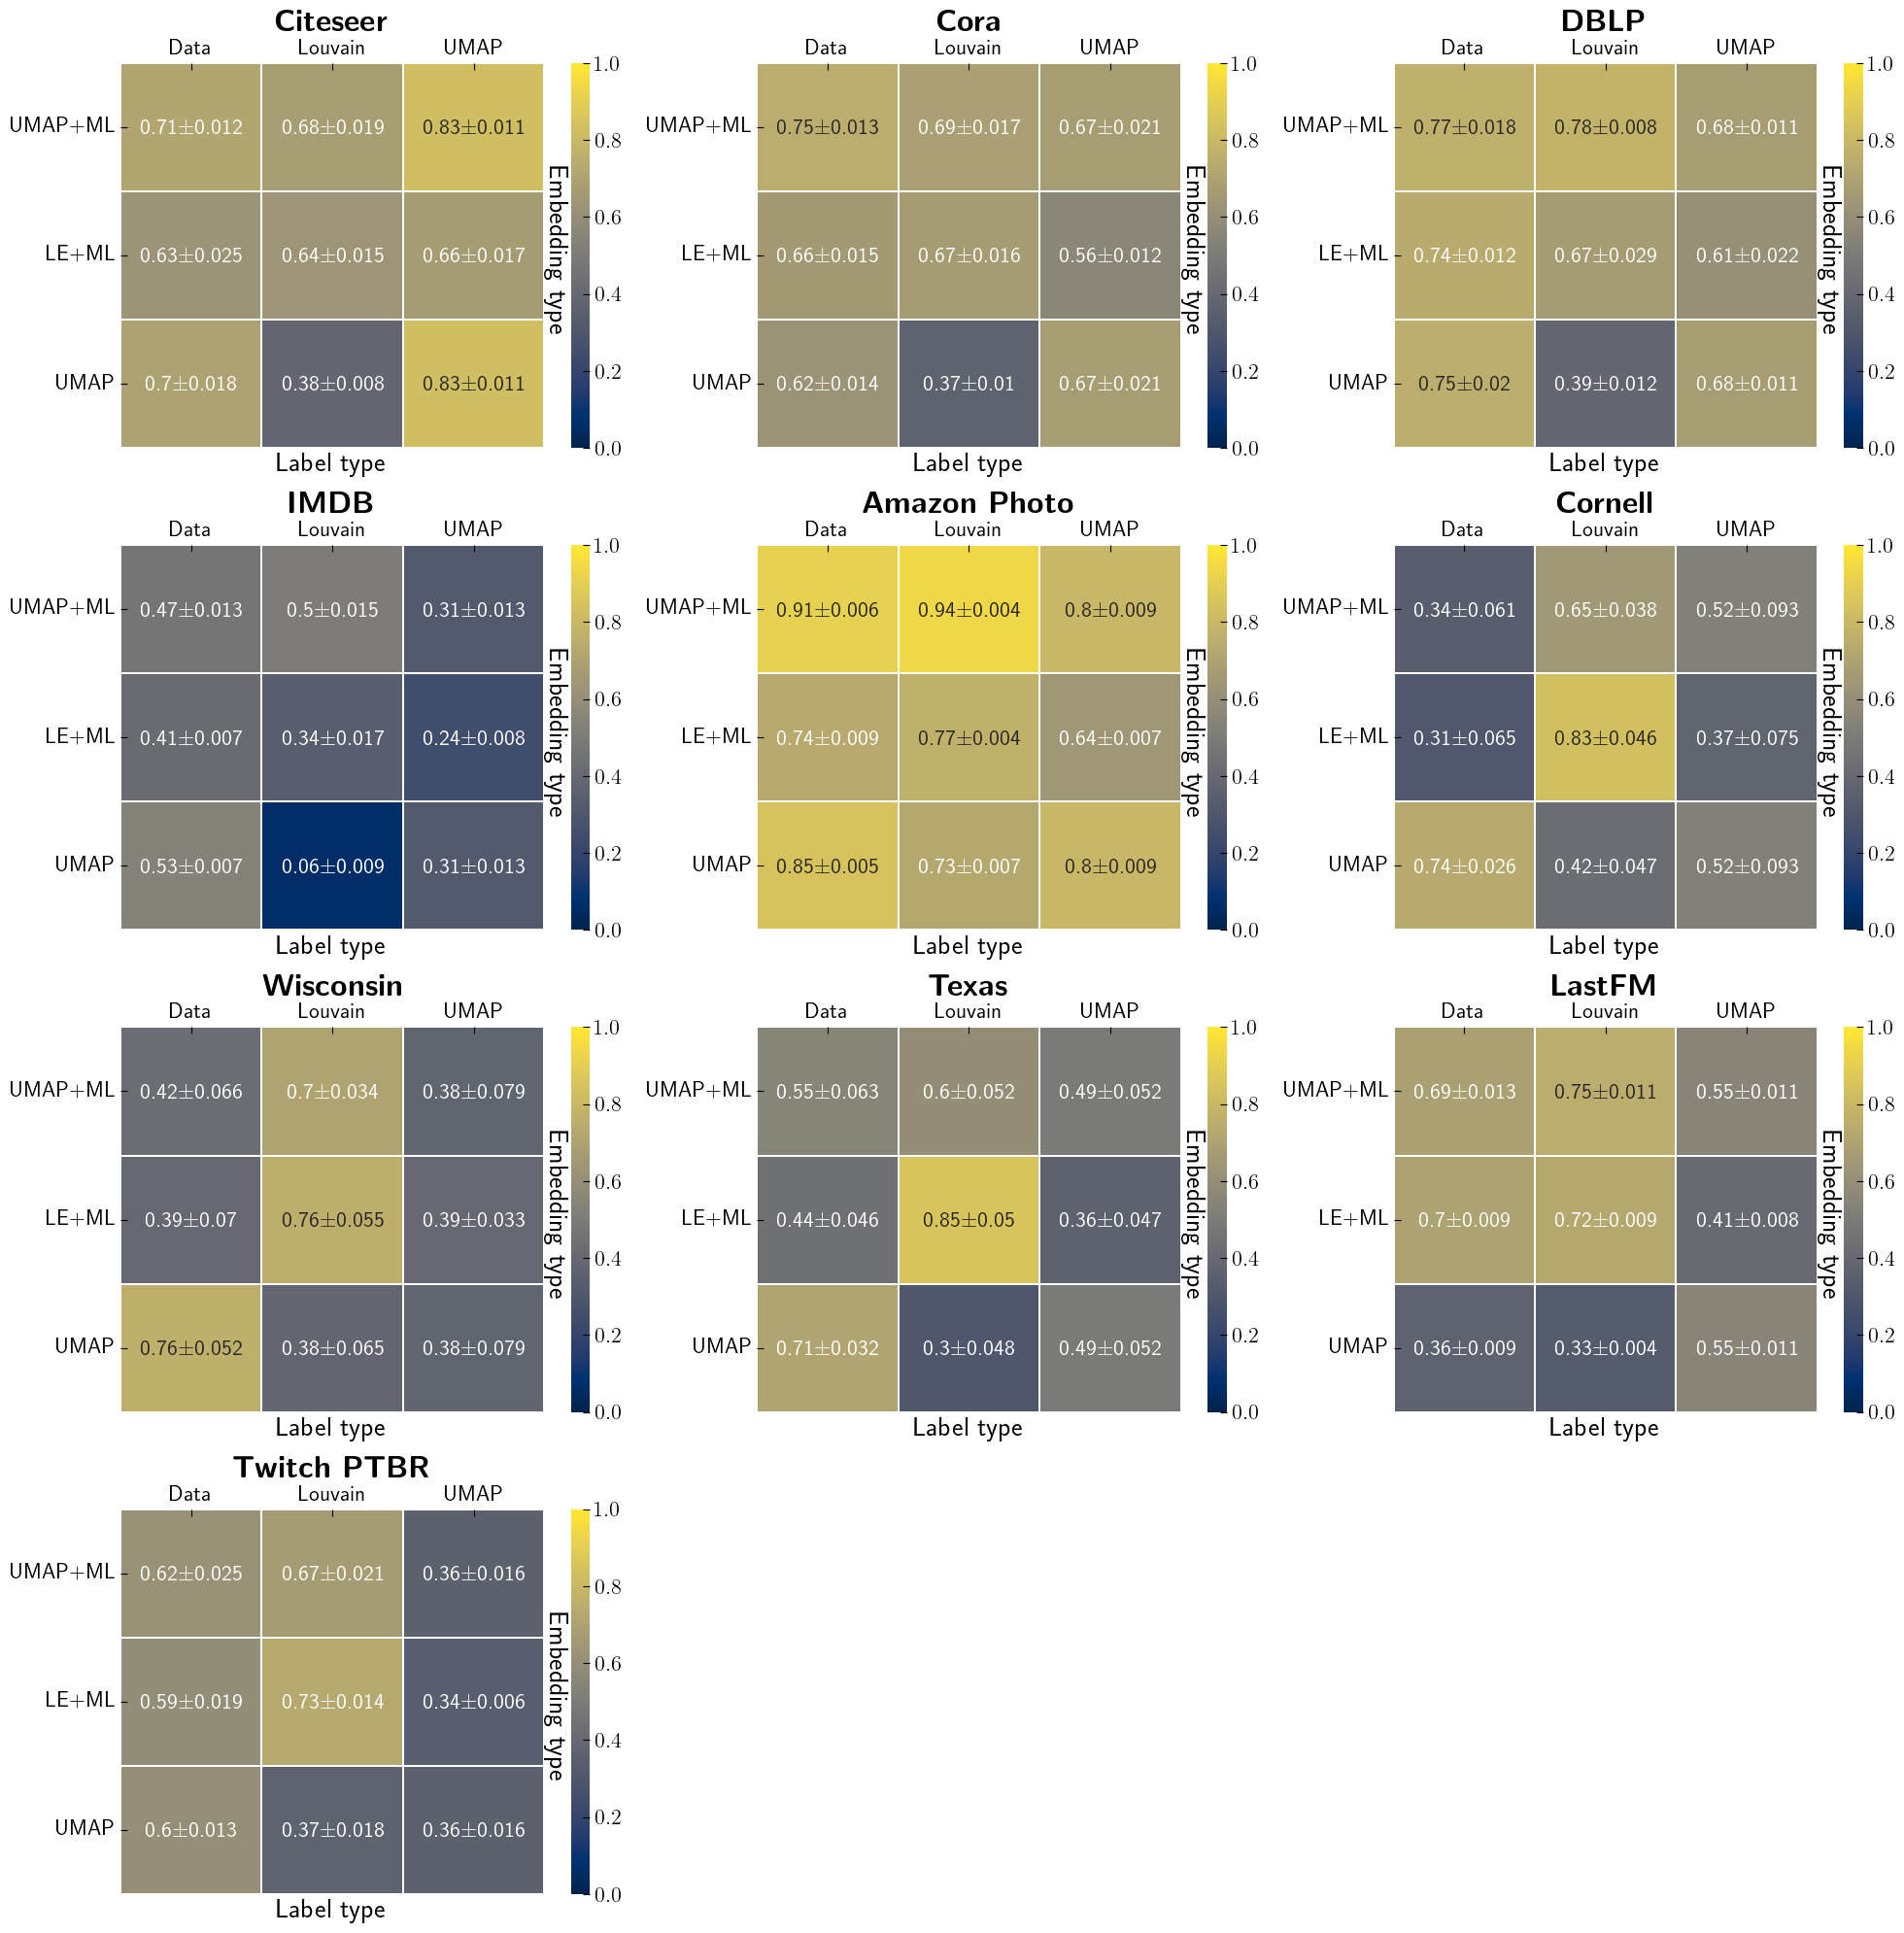

time: 31.9 s (started: 2024-01-10 13:01:03 +01:00)


In [40]:
plt.figure(figsize=(20, 20))

j = 0
for i in range(10):
    plt.subplot(4, 3, j+1)
    j += 1
    plot_heatmap_per_dataset(i, datasets[i])
    
plt.tight_layout()

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.text as text
import matplotlib as mpl


my_cmap = 'cividis'


def plot_heatmap_with_baseline_per_dataset(df, dataset_num, title, ax=None, colorbar=False):
    mat_mean = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean, nc_louvain_labels_mean, nc_umap_labels_mean)])
    mat_std = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std, nc_louvain_labels_std, nc_umap_labels_std)])
    
    mat_mean_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean_rand, nc_louvain_labels_mean_rand, nc_umap_labels_mean_rand)])
    mat_std_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std_rand, nc_louvain_labels_std_rand, nc_umap_labels_std_rand)])
    
    mat_str = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean, decimals=2).astype(str), np.around(mat_std, decimals=3)])
    
    mat_str_rand = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean_rand, decimals=2).astype(str), np.around(mat_std_rand, decimals=3)])
    
    bold_1 = np.full((3, 3), r'\textbf{')
    bold_2 = np.full((3, 3), r'}')
    
    next_line = np.full((3, 3), '\n')
    left_bracket = np.full((3, 3), '(')
    right_bracket = np.full((3, 3), ')')
    
    
    mat_str = np.char.add(bold_1, mat_str)
    mat_str = np.char.add(mat_str, bold_2)

    mat_str = np.char.add(mat_str, next_line)
    mat_str = np.char.add(mat_str, left_bracket)
    mat_str = np.char.add(mat_str, mat_str_rand)
    mat_str = np.char.add(mat_str, right_bracket)
    
    mat_str[-1, -1] = ''
    
    if ax is None:
        ax = sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                    linewidth=0.1, cmap=my_cmap, fmt='', cbar=colorbar)
    else:
        sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                    linewidth=0.1, cmap=my_cmap, fmt='', ax=ax, cbar=colorbar)

    cmap1 = mpl.colors.ListedColormap(['white'])
    sns.heatmap(mat_mean, mask=(mat_str != ''), cmap=cmap1, cbar=False, ax=ax)
    
        
    ax.set(xlabel="Label type")
    ax.text(3, 2.1, "Embedding type", fontsize=20, rotation=-90)
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5], [r"$FiD$-Mercator", r"$D$-Mercator", "UMAP"], rotation=0)
    
    n_labels_data = len(np.unique(df['encoded_label']))
    n_labels_louvain = len(np.unique(df['label_louvain']))
    n_labels_umap = len(np.unique(df['label_clustering_find_k']))
    
    ax.set_xticks([0.5, 1.5, 2.5], 
                  [f"Class ({n_labels_data})", 
                   f"Topology ({n_labels_louvain})", 
                   f"Features ({n_labels_umap})"], 
                  rotation=0)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)
    ax.grid(False)

time: 2.2 ms (started: 2024-01-10 13:01:41 +01:00)


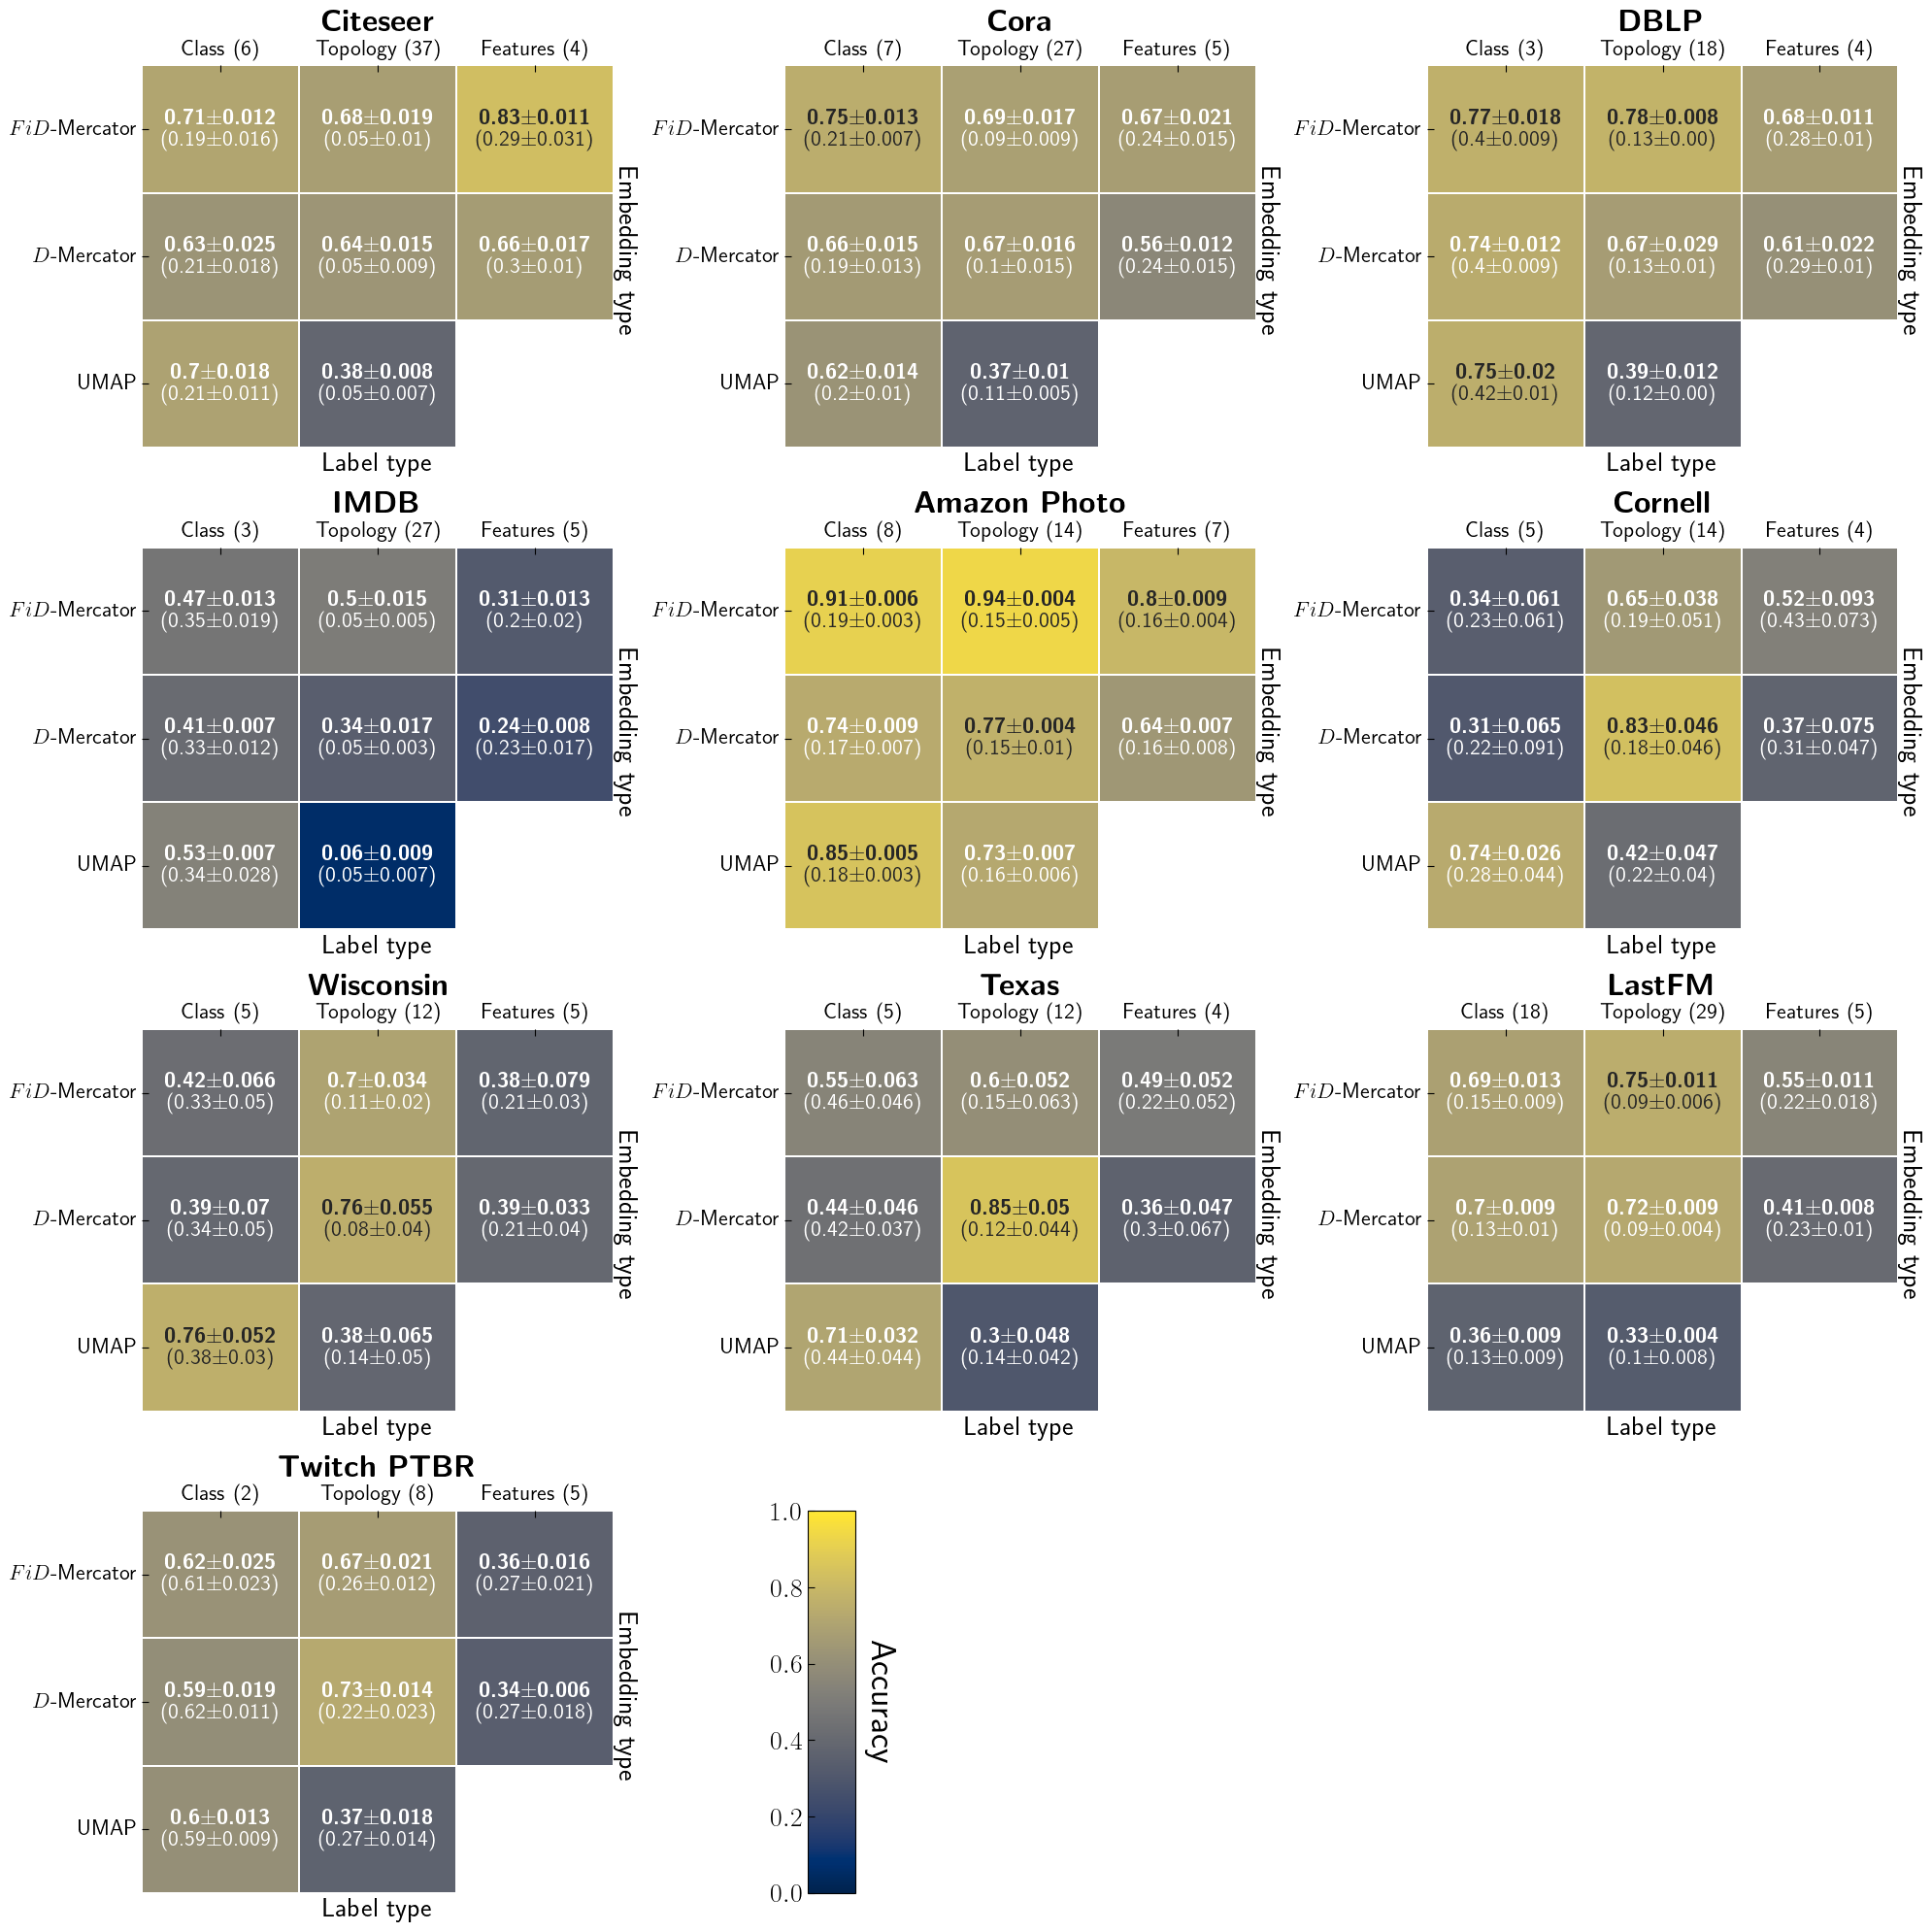

time: 7.44 s (started: 2024-01-10 13:02:33 +01:00)


In [44]:
plt.figure(figsize=(20, 20))

plt.subplot(4, 3, 1)
plot_heatmap_with_baseline_per_dataset(citeseer_only_umap, 0, datasets[0])

plt.subplot(4, 3, 2)
plot_heatmap_with_baseline_per_dataset(cora_only_umap, 1, datasets[1])

plt.subplot(4, 3, 3)
plot_heatmap_with_baseline_per_dataset(dblp_only_umap, 2, datasets[2])

plt.subplot(4, 3, 4)
plot_heatmap_with_baseline_per_dataset(imdb_only_umap, 3, datasets[3])

plt.subplot(4, 3, 5)
plot_heatmap_with_baseline_per_dataset(amazon_photo_only_umap, 4, datasets[4])

plt.subplot(4, 3, 6)
plot_heatmap_with_baseline_per_dataset(cornell_only_umap, 5, datasets[5])

plt.subplot(4, 3, 7)
plot_heatmap_with_baseline_per_dataset(wisconsin_only_umap, 6, datasets[6])

plt.subplot(4, 3, 8)
plot_heatmap_with_baseline_per_dataset(texas_only_umap, 7, datasets[7])

plt.subplot(4, 3, 9)
plot_heatmap_with_baseline_per_dataset(lastfm_only_umap, 8, datasets[8])

plt.subplot(4, 3, 10)
plot_heatmap_with_baseline_per_dataset(twitch_ptbr_only_umap, 9, datasets[9])

plt.subplot(4, 3, 11)

img = plt.imshow(np.array([[0,1]]), cmap=my_cmap)
img.set_visible(False)
clb = plt.colorbar(location='left',aspect=8)
clb.ax.tick_params(labelsize=20) 
clb.ax.set_ylabel('Accuracy', fontsize=26, rotation=270, labelpad=30)
clb.ax.yaxis.set_label_position("right")
# clb.ax.yaxis.tick_right()
plt.axis('off')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/accuracy_heatmap_all_train_0_8.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/SI/plots/accuracy_heatmap_all_train_0_8.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/accuracy_heatmap_all_train_0_8_new_class.pdf")


In [45]:
def plot_heatmap_with_baseline_per_dataset_enlarge(df, dataset_num, title, ax=None, colorbar=False):
    mat_mean = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean, nc_louvain_labels_mean, nc_umap_labels_mean)])
    mat_std = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std, nc_louvain_labels_std, nc_umap_labels_std)])
    
    mat_mean_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean_rand, nc_louvain_labels_mean_rand, nc_umap_labels_mean_rand)])
    mat_std_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std_rand, nc_louvain_labels_std_rand, nc_umap_labels_std_rand)])
    
    mat_str = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean, decimals=2).astype(str), np.around(mat_std, decimals=3)])
    
    mat_str_rand = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean_rand, decimals=2).astype(str), np.around(mat_std_rand, decimals=3)])
    
    bold_1 = np.full((3, 3), r'\textbf{')
    bold_2 = np.full((3, 3), r'}')
    
    next_line = np.full((3, 3), '\n')
    left_bracket = np.full((3, 3), '(')
    right_bracket = np.full((3, 3), ')')
    
    
    mat_str = np.char.add(bold_1, mat_str)
    mat_str = np.char.add(mat_str, bold_2)

    mat_str = np.char.add(mat_str, next_line)
    mat_str = np.char.add(mat_str, left_bracket)
    mat_str = np.char.add(mat_str, mat_str_rand)
    mat_str = np.char.add(mat_str, right_bracket)
    
    mat_str[-1, -1] = ''
    
    if ax is None:
        ax = sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 18},
                    linewidth=0.1, cmap=my_cmap, fmt='', cbar=colorbar)
    else:
        sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 18},
                    linewidth=0.1, cmap=my_cmap, fmt='', ax=ax, cbar=colorbar)

    cmap1 = mpl.colors.ListedColormap(['white'])
    sns.heatmap(mat_mean, mask=(mat_str != ''), cmap=cmap1, cbar=False, ax=ax)
    
        
    #ax.set(xlabel="Label type")
    #ax.text(3, 2.1, "Embedding type", fontsize=22, rotation=-90)
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5], [r"$FiD$-Mercator", r"$D$-Mercator", "UMAP"], 
                  rotation=0, fontsize=22)
    
    n_labels_data = len(np.unique(df['encoded_label']))
    n_labels_louvain = len(np.unique(df['label_louvain']))
    n_labels_umap = len(np.unique(df['label_clustering_find_k']))
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_xticks([0.5, 1.5, 2.5], 
                  [f"Class ({n_labels_data})", 
                   f"Topology ({n_labels_louvain})", 
                   f"Features ({n_labels_umap})"], 
                  rotation=15, fontsize=22)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=24)
    ax.grid(False)
    

time: 2.2 ms (started: 2024-01-10 13:04:58 +01:00)


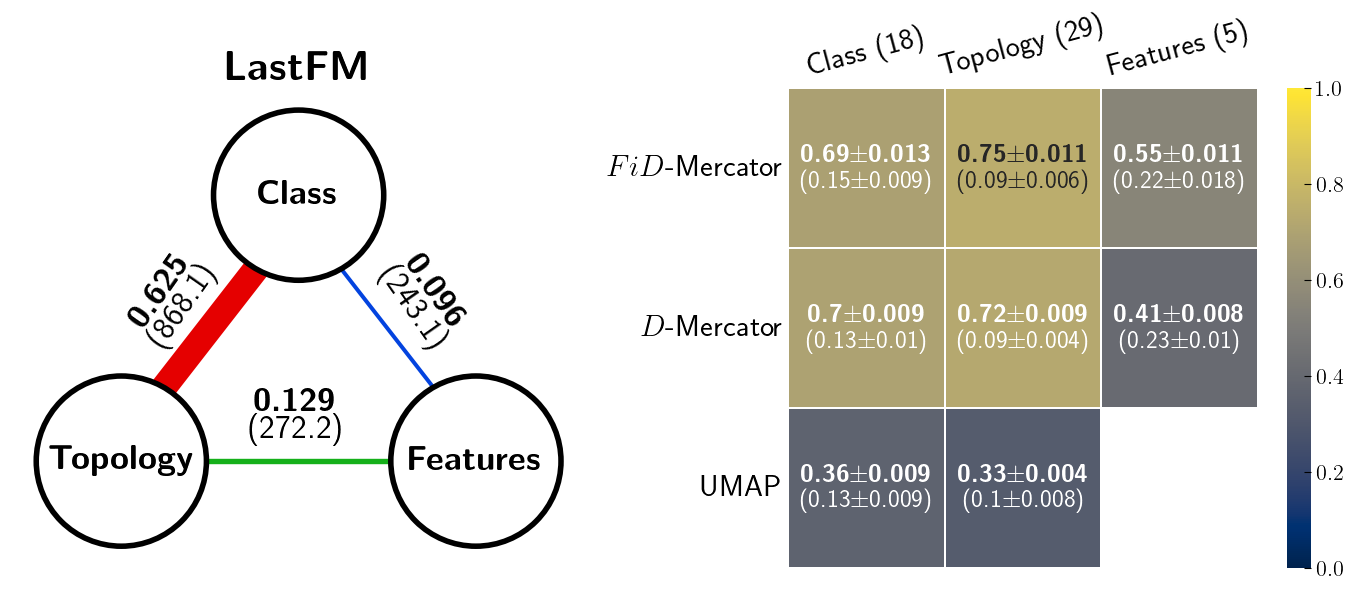

time: 2.56 s (started: 2024-01-10 13:07:07 +01:00)


In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

datasets = ['Citeseer', 'Cora', 'DBLP', 'IMDB', 'Amazon Photo',
            'Cornell', 'Wisconsin', 'Texas', 'LastFM', 'Twitch PTBR']

plot_correlation_triangle_with_random_sigma(lastfm_only_umap, ax[0], 'LastFM')
plot_heatmap_with_baseline_per_dataset_enlarge(lastfm_only_umap, 8, datasets[8], ax=ax[1], colorbar=True)
ax[1].set_title('')
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/lastfm_nmi_triangle_accuracy_heatmap_train_0_8.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/lastfm_nmi_triangle_accuracy_heatmap_train_0_8_large.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/lastfm_nmi_triangle_accuracy_heatmap_train_0_8_large_font.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/lastfm_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font.pdf")


# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/plots/lastfm_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font_new_class.pdf")


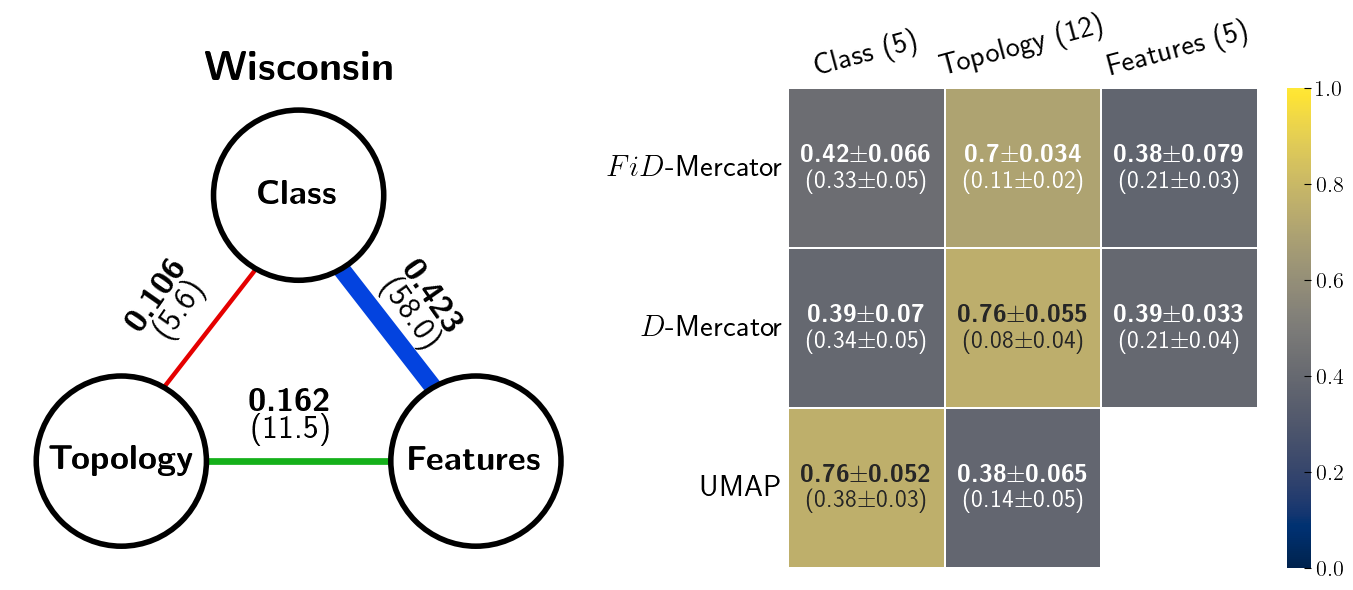

time: 2.4 s (started: 2024-01-10 13:07:21 +01:00)


In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

plot_correlation_triangle_with_random_sigma(wisconsin_only_umap, ax[0], 'Wisconsin')
plot_heatmap_with_baseline_per_dataset_enlarge(wisconsin_only_umap, 6, datasets[6], ax=ax[1], colorbar=True)
ax[1].set_title('')

plt.tight_layout()
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/wisconsin_nmi_triangle_accuracy_heatmap_train_0_8.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/wisconsin_nmi_triangle_accuracy_heatmap_train_0_8_large.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/wisconsin_nmi_triangle_accuracy_heatmap_train_0_8_large_font.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/wisconsin_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/plots/wisconsin_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font_new_class.pdf")


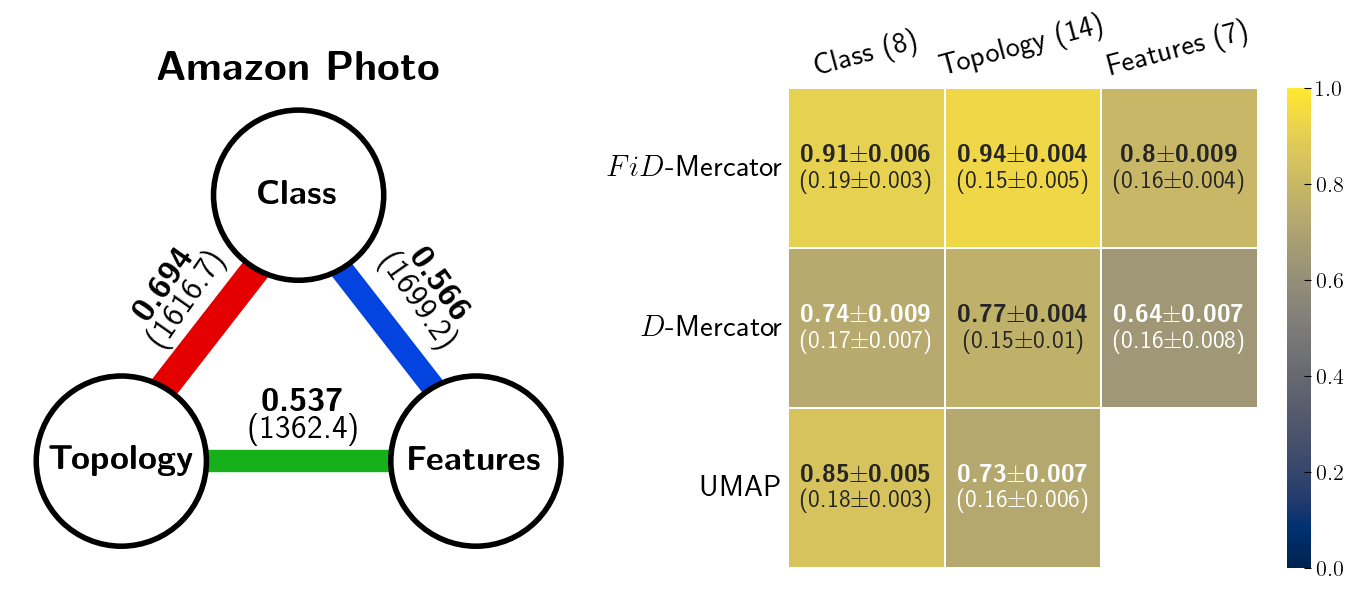

time: 2.55 s (started: 2024-01-10 13:07:40 +01:00)


In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

plot_correlation_triangle_with_random_sigma(amazon_photo_only_umap, ax[0], 'Amazon Photo')
plot_heatmap_with_baseline_per_dataset_enlarge(amazon_photo_only_umap, 4, datasets[4], ax=ax[1], colorbar=True)
ax[1].set_title('')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/amazon_photo_nmi_triangle_accuracy_heatmap_train_0_8_large_font.pdf")
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper1/plots/amazon_photo_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font.pdf")

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/plots/amazon_photo_nmi_triangle_sigma_accuracy_heatmap_train_0_8_large_font_new_class.pdf")


---
---

## Results with Random+ML version

In [62]:
import pickle

datasets = ['Citeseer', 'Cora', 'DBLP', 'IMDB', 'Amazon Photo',
            'Cornell', 'Wisconsin', 'Texas', 'LastFM', 'Twitch PTBR']

# True labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_random_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_true_labels_train_0_8.dat", 'rb') as f:
    nc_true_labels_only_umap = pickle.load(f)

nc_true_labels = [nc_true_labels_umap_ml, nc_true_labels_le_ml, nc_true_labels_random_ml, nc_true_labels_only_umap]

    
# Louvain labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_random_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_only_umap = pickle.load(f)


nc_louvain_labels = [nc_louvain_labels_umap_ml, nc_louvain_labels_le_ml, nc_louvain_labels_random_ml, nc_louvain_labels_only_umap]


# UMAP labels + c_C
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_le_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_umap_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_random_ml = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_umap_labels_cC_train_0_8.dat", 'rb') as f:
    nc_umap_labels_only_umap = pickle.load(f)   

nc_umap_labels = [nc_umap_labels_umap_ml, nc_umap_labels_le_ml, nc_umap_labels_random_ml, nc_umap_labels_only_umap]

time: 7.34 ms (started: 2023-05-31 14:40:48 +02:00)


In [63]:
# True labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_random_ml_rand = pickle.load(f)
    
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_true_labels_random_train_0_8.dat", 'rb') as f:
    nc_true_labels_only_umap_rand = pickle.load(f)

nc_true_labels_rand = [nc_true_labels_umap_ml_rand, nc_true_labels_le_ml_rand, nc_true_labels_random_ml_rand, nc_true_labels_only_umap_rand]

    
# Louvain labels
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_random_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_louvain_labels_random_train_0_8.dat", 'rb') as f:
    nc_louvain_labels_only_umap_rand = pickle.load(f)


nc_louvain_labels_rand = [nc_louvain_labels_umap_ml_rand, nc_louvain_labels_le_ml_rand, nc_louvain_labels_random_ml_rand, nc_louvain_labels_only_umap_rand]


# UMAP labels + c_C
with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_le_ml_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_le_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_umap_ml_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_umap_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_random_ml_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_random_ml_rand = pickle.load(f)

with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/node_classification_only_umap_umap_labels_cC_random_train_0_8.dat", 'rb') as f:
    nc_umap_labels_only_umap_rand = pickle.load(f)   


nc_umap_labels_rand = [nc_umap_labels_umap_ml_rand, nc_umap_labels_le_ml_rand, nc_umap_labels_random_ml_rand, nc_umap_labels_only_umap_rand]

time: 7.67 ms (started: 2023-05-31 14:40:48 +02:00)


In [64]:
nc_true_labels_mean = [np.mean(x, axis=1) for x in nc_true_labels]
nc_true_labels_std = [np.std(x, axis=1) for x in nc_true_labels]

nc_louvain_labels_mean = [np.mean(x, axis=1) for x in nc_louvain_labels]
nc_louvain_labels_std = [np.std(x, axis=1) for x in nc_louvain_labels]

nc_umap_labels_mean = [np.mean(x, axis=1) for x in nc_umap_labels]
nc_umap_labels_std = [np.std(x, axis=1) for x in nc_umap_labels]

time: 1.87 ms (started: 2023-05-31 14:40:49 +02:00)


In [65]:
nc_true_labels_mean_rand = [np.mean(x, axis=1) for x in nc_true_labels_rand]
nc_true_labels_std_rand = [np.std(x, axis=1) for x in nc_true_labels_rand]

nc_louvain_labels_mean_rand = [np.mean(x, axis=1) for x in nc_louvain_labels_rand]
nc_louvain_labels_std_rand = [np.std(x, axis=1) for x in nc_louvain_labels_rand]

nc_umap_labels_mean_rand = [np.mean(x, axis=1) for x in nc_umap_labels_rand]
nc_umap_labels_std_rand = [np.std(x, axis=1) for x in nc_umap_labels_rand]

time: 2.22 ms (started: 2023-05-31 14:40:49 +02:00)


In [66]:
my_cmap = 'cividis'

def plot_heatmap_with_baseline_per_dataset_with_random_ml(df, dataset_num, title, ax=None, colorbar=False):
    mat_mean = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean, nc_louvain_labels_mean, nc_umap_labels_mean)])
    mat_std = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std, nc_louvain_labels_std, nc_umap_labels_std)])
    
    mat_mean_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_mean_rand, nc_louvain_labels_mean_rand, nc_umap_labels_mean_rand)])
    mat_std_rand = np.matrix([(x[dataset_num], y[dataset_num], z[dataset_num]) for x,y,z in zip(
        nc_true_labels_std_rand, nc_louvain_labels_std_rand, nc_umap_labels_std_rand)])
    
    mat_str = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean, decimals=2).astype(str), np.around(mat_std, decimals=3)])
    
    mat_str_rand = np.apply_along_axis(
        r'$\pm$'.join, 0, [np.around(mat_mean_rand, decimals=2).astype(str), np.around(mat_std_rand, decimals=3)])
    
    bold_1 = np.full((4, 3), r'\textbf{')
    bold_2 = np.full((4, 3), r'}')
    
    next_line = np.full((4, 3), '\n')
    left_bracket = np.full((4, 3), '(')
    right_bracket = np.full((4, 3), ')')
    
    
    mat_str = np.char.add(bold_1, mat_str)
    mat_str = np.char.add(mat_str, bold_2)

    mat_str = np.char.add(mat_str, next_line)
    mat_str = np.char.add(mat_str, left_bracket)
    mat_str = np.char.add(mat_str, mat_str_rand)
    mat_str = np.char.add(mat_str, right_bracket)
    
    mat_str[-1, -1] = ''
    
    if ax is None:
        ax = sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                    linewidth=0.1, cmap=my_cmap, fmt='', cbar=colorbar)
    else:
        sns.heatmap(mat_mean, annot=mat_str, vmax=1, vmin=0, annot_kws={"size": 16},
                    linewidth=0.1, cmap=my_cmap, fmt='', ax=ax, cbar=colorbar)

    cmap1 = mpl.colors.ListedColormap(['white'])
    sns.heatmap(mat_mean, mask=(mat_str != ''), cmap=cmap1, cbar=False, ax=ax)
    
        
    ax.set(xlabel="Label type")
    ax.text(3, 2.5, "Embedding type", fontsize=20, rotation=-90)
    ax.xaxis.tick_top()
    ax.set_yticks([0.5, 1.5, 2.5, 3.5], 
                  [r"$D$-Mercator$^U$", r"$D$-Mercator", r"$D$-Mercator$^R$", "UMAP"], rotation=0)
    
    n_labels_data = len(np.unique(df['encoded_label']))
    n_labels_louvain = len(np.unique(df['label_louvain']))
    n_labels_umap = len(np.unique(df['label_clustering_find_k']))
    
    ax.set_xticks([0.5, 1.5, 2.5], 
                  [f"Metadata ({n_labels_data})", 
                   f"Topology ({n_labels_louvain})", 
                   f"Features ({n_labels_umap})"], 
                  rotation=0)
    ax.set_title(rf'\textbf{{{title}}}', fontsize=23)
    ax.grid(False)
    

time: 2.59 ms (started: 2023-05-31 14:40:51 +02:00)


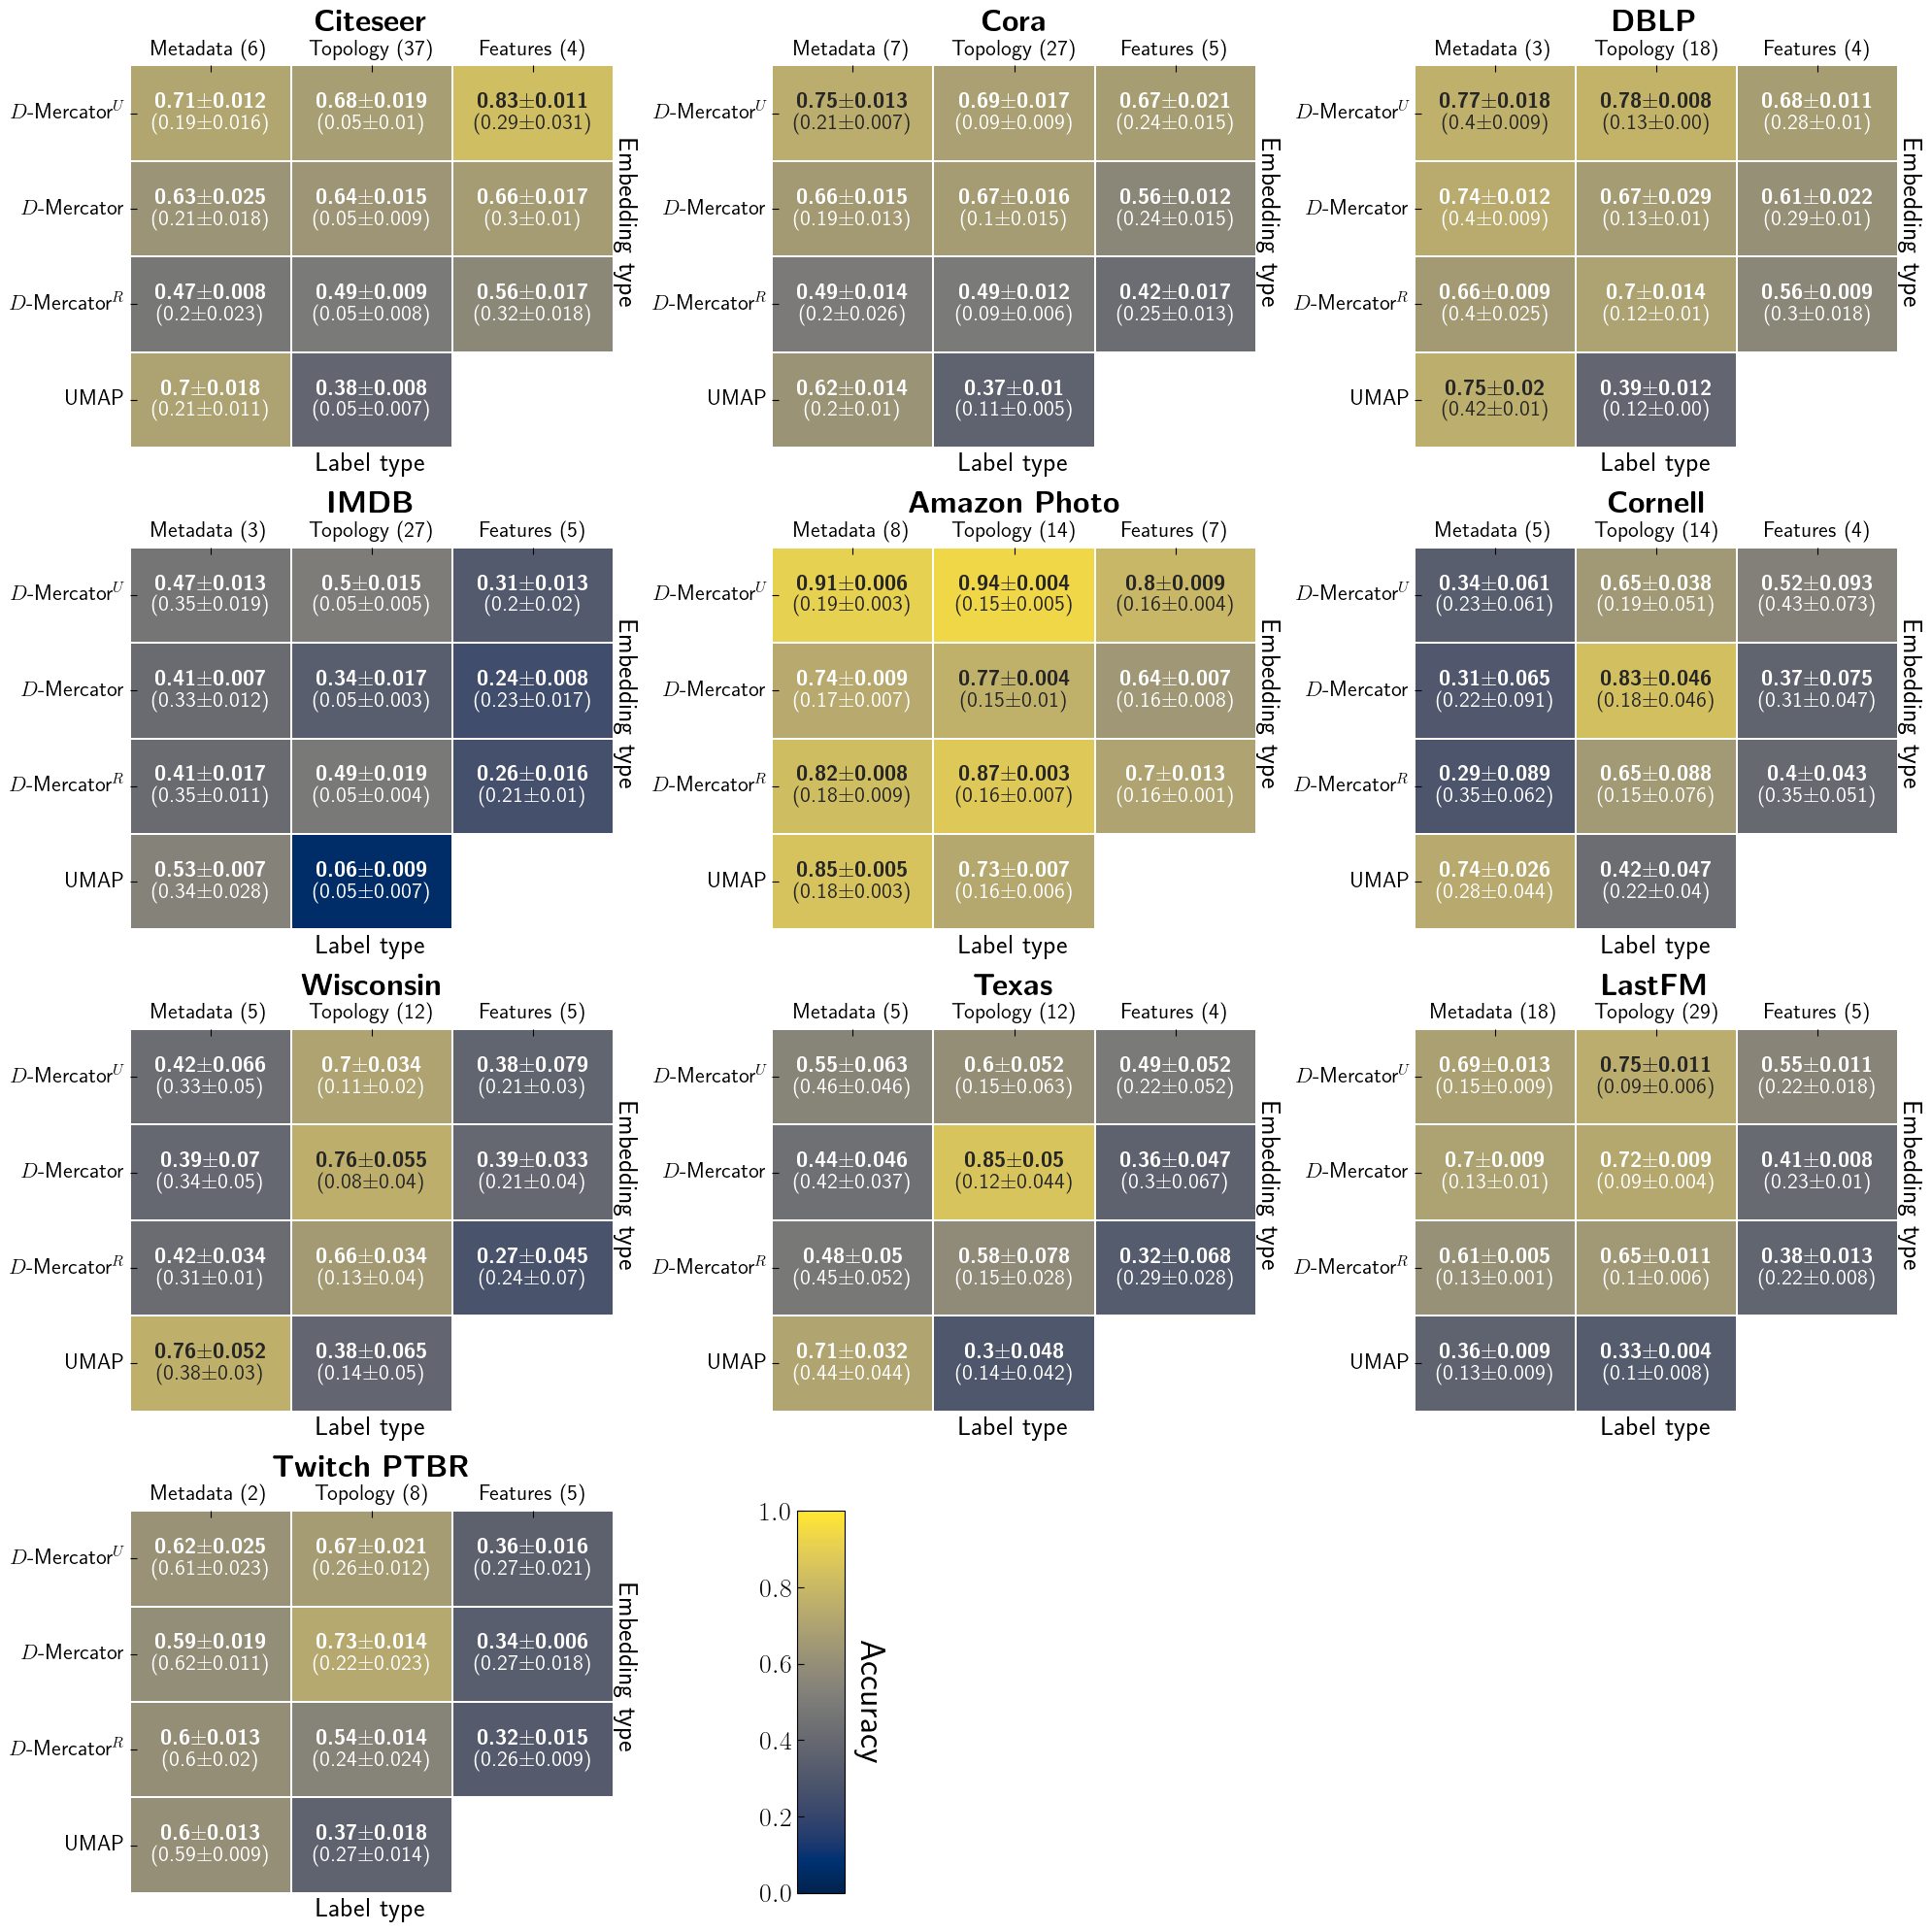

time: 24.6 s (started: 2023-05-31 14:40:52 +02:00)


In [67]:
plt.figure(figsize=(20, 20))

plt.subplot(4, 3, 1)
plot_heatmap_with_baseline_per_dataset_with_random_ml(citeseer_only_umap, 0, datasets[0])

plt.subplot(4, 3, 2)
plot_heatmap_with_baseline_per_dataset_with_random_ml(cora_only_umap, 1, datasets[1])

plt.subplot(4, 3, 3)
plot_heatmap_with_baseline_per_dataset_with_random_ml(dblp_only_umap, 2, datasets[2])

plt.subplot(4, 3, 4)
plot_heatmap_with_baseline_per_dataset_with_random_ml(imdb_only_umap, 3, datasets[3])

plt.subplot(4, 3, 5)
plot_heatmap_with_baseline_per_dataset_with_random_ml(amazon_photo_only_umap, 4, datasets[4])

plt.subplot(4, 3, 6)
plot_heatmap_with_baseline_per_dataset_with_random_ml(cornell_only_umap, 5, datasets[5])

plt.subplot(4, 3, 7)
plot_heatmap_with_baseline_per_dataset_with_random_ml(wisconsin_only_umap, 6, datasets[6])

plt.subplot(4, 3, 8)
plot_heatmap_with_baseline_per_dataset_with_random_ml(texas_only_umap, 7, datasets[7])

plt.subplot(4, 3, 9)
plot_heatmap_with_baseline_per_dataset_with_random_ml(lastfm_only_umap, 8, datasets[8])

plt.subplot(4, 3, 10)
plot_heatmap_with_baseline_per_dataset_with_random_ml(twitch_ptbr_only_umap, 9, datasets[9])

plt.subplot(4, 3, 11)

img = plt.imshow(np.array([[0,1]]), cmap=my_cmap)
img.set_visible(False)
clb = plt.colorbar(location='left',aspect=8)
clb.ax.tick_params(labelsize=20) 
clb.ax.set_ylabel('Accuracy', fontsize=26, rotation=270, labelpad=30)
clb.ax.yaxis.set_label_position("right")
# clb.ax.yaxis.tick_right()
plt.axis('off')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/accuracy_heatmap_all_with_random_ml_train_0_8.pdf")